# Incorporando Análisis de Hofstede en GED

Este notebook trabaja con los datos originados por la iniciativa iGEDS, en particular datos a nivel internacional de 106 países que describen 5 pilares principales:

*   Foundational Institutions
*   Innovation capability
*   Entrepreneurship capability
*   Comparative Advantage
*   Social Impact
*   Economic Impact

Sumado a esto, se incorpora la información de 80 países correspondiente en el análisis antropológico de Hofstede, en el cual se comparan los valores culturales de distintos países con base en un análisis estadístico de las respuestas a un instrumento, o encuesta, que se enfoca en 6 dimensiones:

*   Individualism vs. Collectivism
*   Uncertainty avoidance
*   Power distance ~ strength of social hierarchy
*   Masculinity vs. Feminity
*   Long term orientation
*   Indulgence vs. Self restraint

En este código se realiza lo siguiente

-   Re-escalan todas las métricas a valores entre 1-5 
-   Imputan valores faltantes para algunos paises 
-   Visualiza la distribución de las métricas por país.

## Parte 1: Importe de paquetes de Python, y de Datos 

In [298]:
! pip install pingouin
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import pingouin as pg
import seaborn as sns
import scipy.stats as stats
import networkx as nx

Importe de datos originales:

In [299]:
#data = pd.read_csv('iEcosystems + Hofstede (106 countries dataset) - Indicators.csv')
data = pd.read_csv('iEcosystems + Hofstede (106 countries dataset) (regiónnueva) - Indicators.csv')
data.rename(columns={"Long Term Orientation versus Short Term Normative Orientation (LTO)":"Long Term Orientation (LTO)"}, inplace=True)
#data

## Parte 2: Obtención del Tidy DataFrame

En esta parte obtendremos el **tidy** dataframe, el cual contiene: una característica por columna y una observación por fila. Comenzamos removiendo los valores más altos y bajos, y asignamos el nombre del país como índice: 

In [300]:
minimums = data.iloc[106,4:].astype(float).values
maximums = data.iloc[107,4:].astype(float).values
df = data.drop(axis=0, index=[106,107])
df.set_index('Country', inplace=True)
df

,Region,Region 2,Development Stage,1.01 Ease of doing business (WB),1.02 Starting a business (WB),1.03 Paying taxes (WB),1.04 Resolving Insolvency (WB),1.05 Enforcing contracts (WB),1.06 Property Rights (IEF),1.07 Government Integrity (IEF),...,6.04 Unemployment rate of population 15 years of age and older (SDG 8 - Decent Jobs and Economic Growth),6.05 FDI inward flow as % of GDP (UNCTAD),GNI per capita (WB),SEDA Score (BCG),Power Distance Index (PDI),Individualism versus Collectivism (IDV),Masculinity versus Feminity (MAS),Uncertainty Avoidance Index (UAI),Long Term Orientation (LTO),Indulgence versus Restraint (IVR)
Country,,,,,,,,,,,,,,,,,,,,,
Albania,Europe and Central Asia,Europa,Economies in transition,67.7,91.8,65.2,67.7,53.5,57.1,38.8,...,13.8,8.46,5240,54.3,NaN,NaN,NaN,NaN,61.0,15.0
Algeria,Middle East and North Africa,Oriente Medio,Developing economies,48.6,78.0,53.9,49.2,54.8,37.9,28.3,...,10.2,0.84,3970,43.1,NaN,NaN,NaN,NaN,26.0,32.0
Argentina,Latin America and the Caribbean,Iberoamérica,Developing economies,59.0,80.4,49.3,40.0,57.5,50.5,49.7,...,8.4,2.36,11200,55.8,49.0,46.0,56.0,86.0,20.0,62.0
Armenia,Europe and Central Asia,NaN,Economies in transition,74.5,96.1,81.5,44.6,69.7,60.7,43.4,...,17.7,2.02,4680,50.3,NaN,NaN,NaN,NaN,61.0,NaN
Australia,East Asia and Pacific,NaN,Developed economies,81.2,96.6,85.7,78.9,79.0,82.8,89.3,...,5.6,4.20,54910,81.6,38.0,90.0,61.0,51.0,21.0,71.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
United Kingdom,Europe and Central Asia,Europa,Developed economies,83.5,94.6,86.2,80.3,68.7,92.2,89.9,...,4.3,2.29,42370,76.1,35.0,89.0,66.0,35.0,51.0,69.0
United States,North America,NaN,Developed economies,84.0,91.6,86.8,90.5,73.4,81.8,77.2,...,4.4,1.22,65760,76.3,40.0,91.0,62.0,46.0,26.0,68.0
Uruguay,Latin America and the Caribbean,Iberoamérica,Developing economies,61.5,89.6,70.3,53.6,56.3,72.0,73.5,...,7.9,-1.05,16230,64.0,61.0,36.0,38.0,98.0,26.0,53.0


Proceso de re-escalamiento:

In [301]:
df_scaled = df.copy()
df_scaled = df_scaled.drop('Region', axis=1)
df_scaled = df_scaled.drop('Region 2', axis=1)
df_scaled = df_scaled.drop('Development Stage', axis=1)

columns = df_scaled.columns.values.tolist()

for column, minval, maxval in zip(columns, minimums, maximums):
    df_scaled[column] = df_scaled[column].apply(lambda x: (x-minval)/(maxval-minval))
    df_scaled[column] = df_scaled[column].apply(lambda x: 1+4*x)


df_scaled

,1.01 Ease of doing business (WB),1.02 Starting a business (WB),1.03 Paying taxes (WB),1.04 Resolving Insolvency (WB),1.05 Enforcing contracts (WB),1.06 Property Rights (IEF),1.07 Government Integrity (IEF),1.08 Labor Freedom (IEF),1.09 Trade freedom (IEF),1.10 Corruption Perceptions Index (TI),...,6.04 Unemployment rate of population 15 years of age and older (SDG 8 - Decent Jobs and Economic Growth),6.05 FDI inward flow as % of GDP (UNCTAD),GNI per capita (WB),SEDA Score (BCG),Power Distance Index (PDI),Individualism versus Collectivism (IDV),Masculinity versus Feminity (MAS),Uncertainty Avoidance Index (UAI),Long Term Orientation (LTO),Indulgence versus Restraint (IVR)
Country,,,,,,,,,,,,,,,,,,,,,
Albania,3.708,4.672,3.608,3.708,3.140,3.284,2.552,3.084,4.536,2.44,...,2.549550,3.394919,1.236727,3.172,NaN,NaN,NaN,NaN,3.44,1.60
Algeria,2.944,4.120,3.156,2.968,3.192,2.516,2.132,3.020,3.648,2.40,...,3.198198,2.515012,1.174866,2.724,NaN,NaN,NaN,NaN,2.04,2.28
Argentina,3.360,4.216,2.972,2.600,3.300,3.020,2.988,2.860,3.768,2.60,...,3.522523,2.690531,1.527034,3.232,2.96,2.84,3.24,4.44,1.80,3.48
Armenia,3.980,4.844,4.260,2.784,3.788,3.428,2.736,3.900,4.224,2.40,...,1.846847,2.651270,1.209450,3.012,NaN,NaN,NaN,NaN,3.44,NaN
Australia,4.248,4.864,4.428,4.156,4.160,4.312,4.572,4.360,4.528,4.08,...,4.027027,2.903002,3.656113,4.264,2.52,4.60,3.44,3.04,1.84,3.84
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
United Kingdom,4.340,4.784,4.448,4.212,3.748,4.688,4.596,3.924,4.456,4.20,...,4.261261,2.682448,3.045300,4.044,2.40,4.56,3.64,2.40,3.04,3.76
United States,4.360,4.664,4.472,4.620,3.936,4.272,4.088,4.516,4.192,3.84,...,4.243243,2.558891,4.184608,4.052,2.60,4.64,3.48,2.84,2.04,3.72
Uruguay,3.460,4.584,3.812,3.144,3.252,3.880,3.940,3.840,4.096,3.80,...,3.612613,2.296767,1.772041,3.560,3.44,2.44,2.52,4.92,2.04,3.12


In [302]:
#sum(list(data.isnull().sum()))      #919
#sum(list(df.isnull().sum()))        #913
sum(list(df_scaled.isnull().sum())) #886

886

Con esto tenemos los datos re-escalados del 1-5. Aún así, algunas entradas tienen valores faltantes, dichos valores se van a inferir con la técnica de **K-vecinos cercanos**, considerando los 5 vecinos más cercanos. Total de valores faltantes: 886.

In [303]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5)
var = imputer.fit_transform(df_scaled)
df_imputed = pd.DataFrame(var)
var = np.where(var>5,5,var)      #adjust values to 5 or 1 when these are out of bounds
var = np.where(var<1,1,var)

df_imputed.columns = columns
df_imputed.index = df_scaled.index
#pd.set_option('max_columns', None, 'max_rows', None)
df_imputed.head()
#df_imputed

,1.01 Ease of doing business (WB),1.02 Starting a business (WB),1.03 Paying taxes (WB),1.04 Resolving Insolvency (WB),1.05 Enforcing contracts (WB),1.06 Property Rights (IEF),1.07 Government Integrity (IEF),1.08 Labor Freedom (IEF),1.09 Trade freedom (IEF),1.10 Corruption Perceptions Index (TI),...,6.04 Unemployment rate of population 15 years of age and older (SDG 8 - Decent Jobs and Economic Growth),6.05 FDI inward flow as % of GDP (UNCTAD),GNI per capita (WB),SEDA Score (BCG),Power Distance Index (PDI),Individualism versus Collectivism (IDV),Masculinity versus Feminity (MAS),Uncertainty Avoidance Index (UAI),Long Term Orientation (LTO),Indulgence versus Restraint (IVR)
Country,,,,,,,,,,,,,,,,,,,,,
Albania,3.708,4.672,3.608,3.708,3.140,3.284,2.552,3.084,4.536,2.44,...,2.549550,3.394919,1.236727,3.172,3.760,1.664,2.680,4.248,3.44,1.60
Algeria,2.944,4.120,3.156,2.968,3.192,2.516,2.132,3.020,3.648,2.40,...,3.198198,2.515012,1.174866,2.724,3.552,2.256,3.056,3.936,2.04,2.28
Argentina,3.360,4.216,2.972,2.600,3.300,3.020,2.988,2.860,3.768,2.60,...,3.522523,2.690531,1.527034,3.232,2.960,2.840,3.240,4.440,1.80,3.48
Armenia,3.980,4.844,4.260,2.784,3.788,3.428,2.736,3.900,4.224,2.40,...,1.846847,2.651270,1.209450,3.012,3.896,2.608,3.128,3.896,3.44,2.04
Australia,4.248,4.864,4.428,4.156,4.160,4.312,4.572,4.360,4.528,4.08,...,4.027027,2.903002,3.656113,4.264,2.520,4.600,3.440,3.040,1.84,3.84


In [304]:
sum(list(df_imputed.isnull().sum()))

0

## Parte 3: DataFrame organizado por pilares

Tenemos los datos limpios, re-escalados, sin valores faltantes. Podemos ahora podemos reorganizar nuestros datos como sigue: tomaremos registro del pilar al que corresponde cada métrica de iEcosystems.

Consideramos cada una de las dimensiones de Hofstede como pilar en este proceso de reorganización.

In [305]:
hofstede_pillars = ['Power Distance Index (PDI)',
            'Individualism versus Collectivism (IDV)',
            'Masculinity versus Feminity (MAS)', 
            'Uncertainty Avoidance Index (UAI)',
            'Long Term Orientation (LTO)',
            'Indulgence versus Restraint (IVR)']


In [306]:
df_means = df_imputed.T

pillars = pd.read_excel('https://github.com/NunezKant/iGEDS/blob/master/iEcosystems%20(106%20countries%20dataset).xlsx?raw=true', decimal = ',', sheet_name=1)
pillars = pillars['Pillar'].values
pillars = np.append(pillars, hofstede_pillars, axis=0)

df_means['Pillars'] = pillars
df_means


Country,Albania,Algeria,Argentina,Armenia,Australia,Austria,Azerbaijan,Bangladesh,Belgium,Bosnia and Herzegovina,...,Tunisia,Turkey,Ukraine,United Arab Emirates,United Kingdom,United States,Uruguay,Vietnam,Zambia,Pillars
1.01 Ease of doing business (WB),3.708,2.944,3.360,3.980,4.248,4.148,4.068,2.800,4.000,3.616,...,3.748,4.072,3.808,4.236,4.340,4.360,3.460,3.792,3.676,1 Foundational Institutions
1.02 Starting a business (WB),4.672,4.120,4.216,4.844,4.864,4.328,4.848,4.296,4.692,3.400,...,4.784,4.552,4.644,4.792,4.784,4.664,4.584,4.404,4.396,1 Foundational Institutions
1.03 Paying taxes (WB),3.608,3.156,2.972,4.260,4.428,4.340,4.360,3.244,4.136,3.416,...,3.776,4.464,4.124,4.412,4.448,4.472,3.812,3.760,4.556,1 Foundational Institutions
1.04 Resolving Insolvency (WB),3.708,2.968,2.600,2.784,4.156,4.096,3.540,2.124,4.364,3.728,...,3.168,2.540,2.256,2.972,4.212,4.620,3.144,2.520,2.972,1 Foundational Institutions
1.05 Enforcing contracts (WB),3.140,3.192,3.300,3.788,4.160,4.020,3.812,1.888,3.572,3.312,...,3.336,3.856,3.544,4.036,3.748,3.936,3.252,3.484,3.032,1 Foundational Institutions
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Individualism versus Collectivism (IDV),1.664,2.256,2.840,2.608,4.600,3.200,1.896,1.800,4.000,3.080,...,2.288,2.480,1.928,3.800,4.560,4.640,2.440,1.800,1.504,Individualism versus Collectivism (IDV)
Masculinity versus Feminity (MAS),2.680,3.056,3.240,3.128,3.440,4.160,2.960,3.200,3.160,2.984,...,2.768,2.800,2.808,2.896,3.640,3.480,2.520,2.600,2.856,Masculinity versus Feminity (MAS)
Uncertainty Avoidance Index (UAI),4.248,3.936,4.440,3.896,3.040,3.800,3.680,3.400,4.760,3.760,...,4.088,4.400,3.832,3.264,2.400,2.840,4.920,2.200,4.328,Uncertainty Avoidance Index (UAI)
Long Term Orientation (LTO),3.440,2.040,1.800,3.440,1.840,3.400,3.440,2.880,4.280,3.800,...,2.464,2.840,4.440,2.952,3.040,2.040,2.040,3.280,2.200,Long Term Orientation (LTO)


Tomaremos la media por pilar de cada país. 

In [307]:
df_means = df_means.groupby('Pillars').mean().T
df_means

Pillars,1 Foundational Institutions,2.01 I-Human Capital,2.02 I-Funding,2.03 I-Infrastructure,2.04 I-Demand,2.05 I-Culture & Incentives,3.01 E-Human Capital,3.02 E-Funding,3.03 E-Infrastructure,3.04 E-Demand,...,5 Social Impact,6 Economic Impact,GNI per capita,Individualism versus Collectivism (IDV),Indulgence versus Restraint (IVR),Long Term Orientation (LTO),Masculinity versus Feminity (MAS),Power Distance Index (PDI),SEDA Score,Uncertainty Avoidance Index (UAI)
Country,,,,,,,,,,,,,,,,,,,,,
Albania,3.4732,2.207633,1.337470,2.598926,2.929778,1.5660,3.428110,2.045130,3.478800,2.3690,...,3.935356,2.738519,1.236727,1.664,1.60,3.44,2.680,3.760,3.172,4.248
Algeria,3.0096,2.192006,1.674710,2.383803,2.573333,2.4276,3.182732,1.738879,3.473333,3.2058,...,3.715319,2.324024,1.174866,2.256,2.28,2.04,3.056,3.552,2.724,3.936
Argentina,3.1684,2.021985,1.682002,2.740698,2.729778,1.7930,3.076940,1.725475,3.679067,3.1718,...,3.984246,2.405071,1.527034,2.840,3.48,1.80,3.240,2.960,3.232,4.440
Armenia,3.6344,2.187459,1.398630,2.837184,2.718222,1.3420,3.314949,2.167727,3.614267,2.6556,...,3.820191,3.070693,1.209450,2.608,2.04,3.44,3.128,3.896,3.012,3.896
Australia,4.3708,2.878032,2.064750,3.294983,3.268889,2.8508,3.752603,2.823880,4.229333,3.4370,...,4.423548,3.275445,3.656113,4.600,3.84,1.84,3.440,2.520,4.264,3.040
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
United Kingdom,4.3396,3.340008,1.967984,3.715226,3.709333,3.9660,2.853192,3.973914,4.286000,3.8236,...,4.134732,3.079245,3.045300,4.560,3.76,3.04,3.640,2.400,4.044,2.400
United States,4.2960,3.199162,3.764866,3.606783,4.223556,3.4960,3.722513,7.088756,4.288533,4.3330,...,3.863439,3.335960,4.184608,4.640,3.72,2.04,3.480,2.600,4.052,2.840
Uruguay,3.7808,2.346297,1.464989,2.833698,2.578222,1.2428,3.046434,2.006035,3.926000,2.7408,...,4.495705,2.605598,1.772041,2.440,3.12,2.04,2.520,3.440,3.560,4.920


## Parte 4: Correlaciones de los promedios de pilares

Ahora podemos obtener la matriz de correlación, a partir de la cual podemos plantear preguntas acerca de cómo se relacionan los diferentes pilares que estamos estudiando. 

Primero que nada, nuestras principales herramientas:

*   `significant_corr`: para cualesquiera dos columnas obtiene su correlación Pearson
*   `print_significant_corr`: si la correlación es estadísticamente significativa, imprime dicha información y grafica el conjunto de datos evaluado en estos dos pilares

In [308]:
def significant_corr(df1,df2,a,b):
    '''
    This function computed the pearson correlation between two data sets a, b, 
    and determines whether this correlation is significant or not. 
    
    Inputs:
    - df1  : a DataFrame
    - df2  : a DataFrame
    - a    : a data vector
    - b    : a data vector
    
    Output : a tuple (B,N) where B is a boolean that answers the question:
    ~do a and b present significant correlation? i.e. p-value<0.1,
    and N=0 is B=False, or N=p-val(a,b) if B=True
    '''
    if df2.empty:
        df2=df1
    r = stats.pearsonr(df1[a], df2[b])
    if r[1] < 0.05:
    #if r[1] < 0.2:
        return (True, r[0], r[1])
    else:
        return (False, r[0], r[1])
    
    
    

def print_significant_corr(df1,df2,a,b):
    '''
    This function computes the Pearson correlation between two data sets a, b, 
    and prints whether this correlation is significant or not, and the 
    corresponding Pearson correlation and p-value. 
    
    Inputs:
    - df1  : a DataFrame
    - df2  : a DataFrame
    - a    : a data vector
    - b    : a data vector
    
    Output : None, but executes print statements showing the findings about aand b.
    '''
    if df2.empty:
        df2=df1
    r = stats.pearsonr(df1[a], df2[b])
    print(f'Correlation between:  ' + a + '   and   ' + b)
    print('**********************************************')
    print(f'Pearson Correlation: {r[0]}, p-value: {r[1]}')
    
    #if r[1] < 0.05:
    if r[1] < 0.2:
        print('*Statistically significant*')
        print('***********************************************')
        print('')
        sns.lmplot(x=b, y=a, data=df1)
        return True, r[0], r[1]
    
    else:
        print('Not significant')
        print('**********************************************')
        print('')
        sns.lmplot(x=b, y=a, data=df1)
        return False, r[0], r[1]

    
    
def significant_corr_many(df1,df2,a,L,nameL):
    '''
    This function computes the Pearson correlation between two data sets a, b, 
    and prints whether this correlation is significant or not, and the 
    corresponding Pearson correlation and p-value. 
    
    Inputs:
    - df1  : a DataFrame
    - df2  : a DataFrame
    - a    : a data vector
    - L    : a collection of data vectors
    - nameL: string to explain what type of information the vectors in L provide 
    
    Output : None, but executes print statements showing the findings about aand b.
    '''
    sig_corrs = {nameL:[], 'Pearson Correlation':[], 'Pvalue':[]}
    
    if df2.empty:
        df2=df1
    for b in L:
        r = stats.pearsonr(df1[a], df2[b])
        #if r[1] < 0.05:
        if r[1] < 0.2:
            sig_corrs[nameL].append(b)
            sig_corrs['Pearson Correlation'].append(r[0])
            sig_corrs['Pvalue'].append(r[1])
    return pd.DataFrame(sig_corrs)

Nos interesa como se relacionan las métricas con las variables de salida:

*   4 Comparative Advantage
*   5 Impact

Primero obtenemos la matriz de correlaciones y la representamos visualmente por medio de un Heatmap:

In [309]:
corr = df_means.corr()

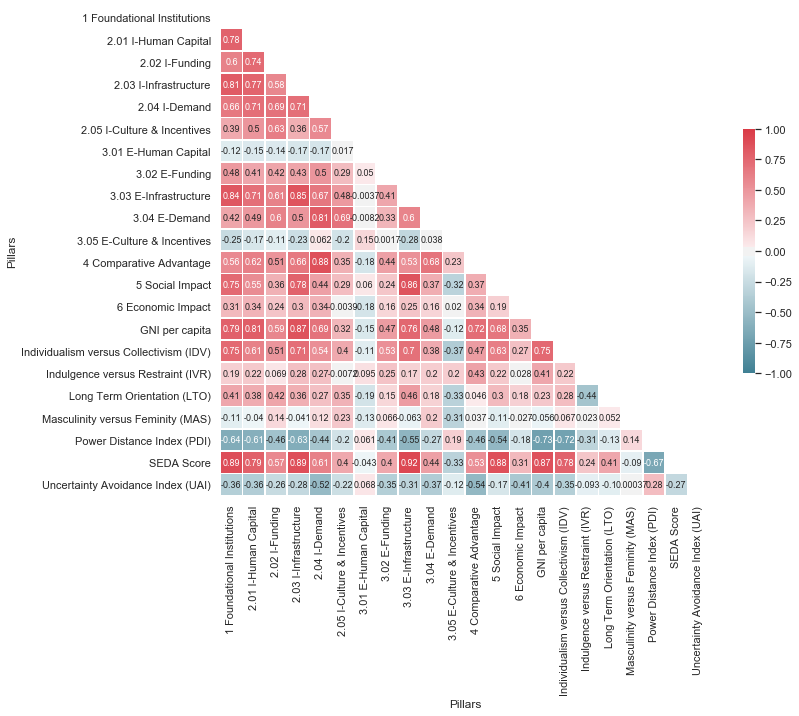

In [310]:
import seaborn as sns
sns.set(style="white")

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap,annot=True,vmin=-1, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot_kws={"size": 9})

## Parte 5: Unificación de Pilares de Innovación y de Emprendimiento

Los pilares de capacidades de Innovación (2) y Emprendimiento (3) son el enfoque de esta parte del código. En particular nos interesa ver qué sucede al unificar cada uno de estos pilares, por separado, y qué sucede cuando unificamos los dos pilares. 

In [311]:
#i_e_unified = df_means.T.copy()
i_e_unified = df_imputed.T.copy()
pillars_L = pillars.copy()

for i in range(len(pillars_L)):
    if pillars_L[i][0] == '2':
        pillars_L[i] = '2 Innovation Capacity'
    elif pillars_L[i][0] == '3':
        pillars_L[i] = '3 Entrepreneurship Capacity'

i_e_unified['Pillar'] = pillars_L
i_e_unified = i_e_unified.groupby('Pillar').mean().T
        
'''
#building i_e_unified
pillars_L = ['1 Foundational Institutions']
pillars_L += ['2 Innovation Capacity']*5 
pillars_L += ['3 Entrepreneurship Capacity']*5 
pillars_L += ['4 Comparative Advantage', 
                          '5 Social Impact',
                          '6 Economic Impact']
                          'GNI per capita' ,
                          '8 SEDA Score']
pillars_L += hofstede_pillars
i_e_unified['Pillar'] = pillars_L
i_e_unified = i_e_unified.groupby('Pillar').mean().T
'''

# Unify I&E capacity - each pilars contains 5 components
combined_L=[]
for i in range(len(i_e_unified['2 Innovation Capacity'])):
    icap = i_e_unified['2 Innovation Capacity'][i]
    ecap = i_e_unified['3 Entrepreneurship Capacity'][i]
    combined_L.append(0.5*icap + 0.5*ecap)
i_e_unified['2&3 I&E Capacity'] = combined_L
#i_e_unified



# Unify S&E impact - each pilar contains 5 components
combined_L=[]
for i in range(len(i_e_unified['5 Social Impact'])):
    socim = i_e_unified['5 Social Impact'][i]
    ecoim = i_e_unified['6 Economic Impact'][i]
    combined_L.append(0.5*socim + 0.5*ecoim)
i_e_unified['5&6 Impact'] = combined_L
i_e_unified

Pillar,1 Foundational Institutions,2 Innovation Capacity,3 Entrepreneurship Capacity,4 Comparative Advantage,5 Social Impact,6 Economic Impact,GNI per capita,Individualism versus Collectivism (IDV),Indulgence versus Restraint (IVR),Long Term Orientation (LTO),Masculinity versus Feminity (MAS),Power Distance Index (PDI),SEDA Score,Uncertainty Avoidance Index (UAI),2&3 I&E Capacity,5&6 Impact
Country,,,,,,,,,,,,,,,,
Albania,3.4732,2.150283,2.794764,2.074467,3.935356,2.738519,1.236727,1.664,1.60,3.44,2.680,3.760,3.172,4.248,2.472523,3.336937
Algeria,3.0096,2.209405,2.828250,2.399133,3.715319,2.324024,1.174866,2.256,2.28,2.04,3.056,3.552,2.724,3.936,2.518827,3.019672
Argentina,3.1684,2.198670,2.696591,2.583067,3.984246,2.405071,1.527034,2.840,3.48,1.80,3.240,2.960,3.232,4.440,2.447630,3.194659
Armenia,3.6344,2.151068,2.992900,2.593067,3.820191,3.070693,1.209450,2.608,2.04,3.44,3.128,3.896,3.012,3.896,2.571984,3.445442
Australia,4.3708,2.852076,3.278560,3.316533,4.423548,3.275445,3.656113,4.600,3.84,1.84,3.440,2.520,4.264,3.040,3.065318,3.849496
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
United Kingdom,4.3396,3.249605,3.631231,3.884867,4.134732,3.079245,3.045300,4.560,3.76,3.04,3.640,2.400,4.044,2.400,3.440418,3.606989
United States,4.2960,3.619171,4.871043,4.095000,3.863439,3.335960,4.184608,4.640,3.72,2.04,3.480,2.600,4.052,2.840,4.245107,3.599700
Uruguay,3.7808,2.174806,2.826071,2.482667,4.495705,2.605598,1.772041,2.440,3.12,2.04,2.520,3.440,3.560,4.920,2.500438,3.550652


Obtención de la matriz de correlaciones y la visualización por medio de un Heatmap:

In [312]:
corr = i_e_unified.corr()

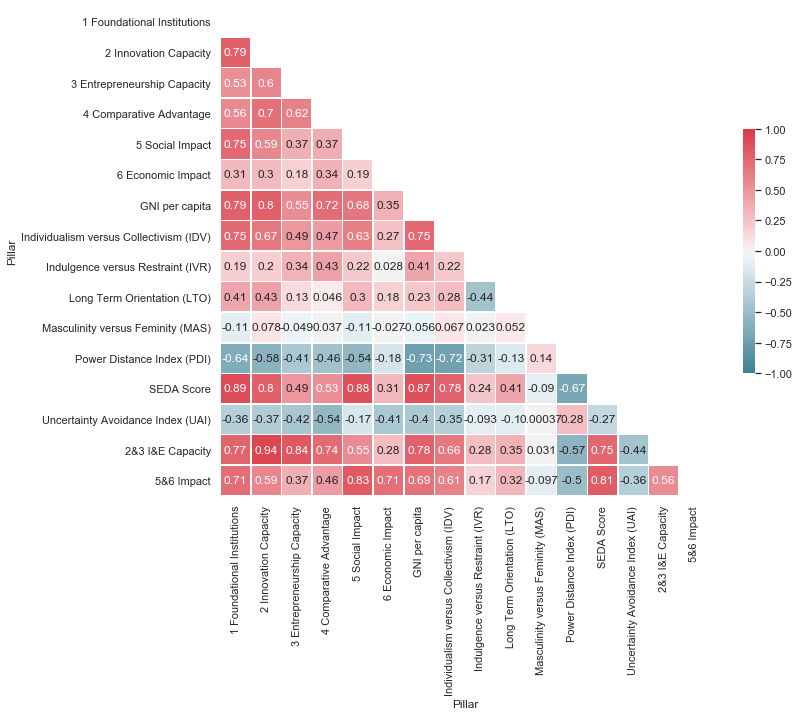

In [313]:
import seaborn as sns
sns.set(style="white")

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
#cmap = sns.diverging_palette(10, 190, as_cmap=True)


# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, annot=True,vmin=-1, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

Para completar la lectura del Heatmap anteriormente presentado, enlistamos la lista de aquellas parejas de columnas del DataFrame `i_e_unified` que tienen una correlación significativa. 

*Nota*: las correlaciones siguientes son para el conjunto de 106 países.   

_-_-_-_-_-_-_-_
Power Distance Index (PDI)
_-_-_-_-_-_-_-_
Correlation between:  Power Distance Index (PDI)   and   5 Social Impact
**********************************************
Pearson Correlation: -0.5447348615227983, p-value: 1.5744164983988523e-09
*Statistically significant*
***********************************************




Correlation between:  Power Distance Index (PDI)   and   5&6 Impact
**********************************************
Pearson Correlation: -0.4952623676663871, p-value: 6.76782830608693e-08
*Statistically significant*
***********************************************




Correlation between:  Power Distance Index (PDI)   and   SEDA Score
**********************************************
Pearson Correlation: -0.6724124449353339, p-value: 2.956594346318602e-15
*Statistically significant*
***********************************************




Correlation between:  Power Distance Index (PDI)   and   GNI per capita
**********************************************
Pearson Corre

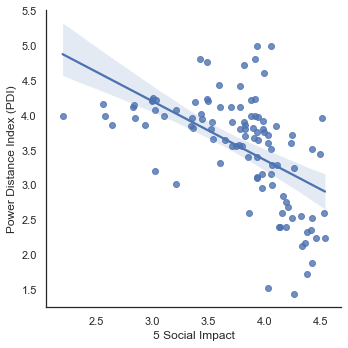

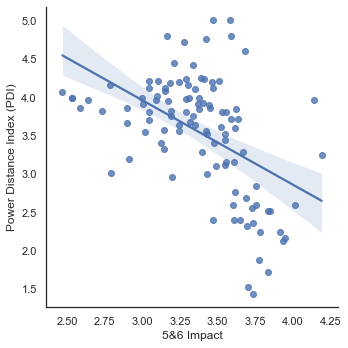

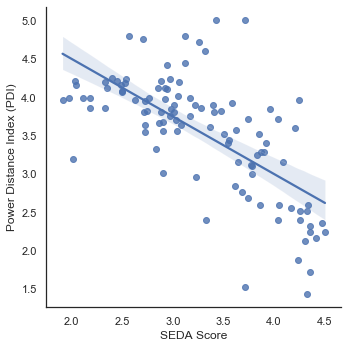

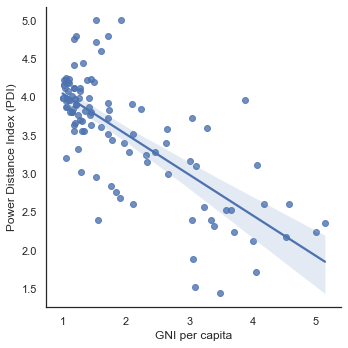

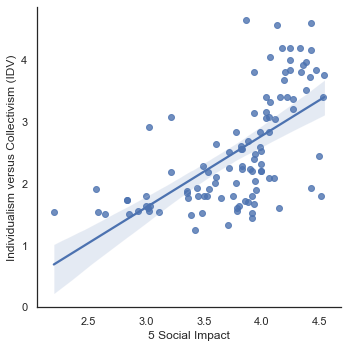

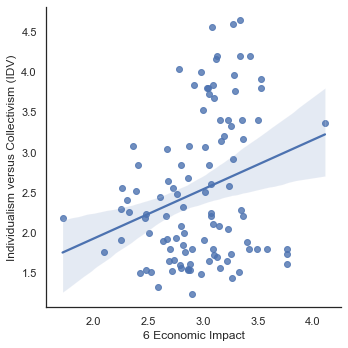

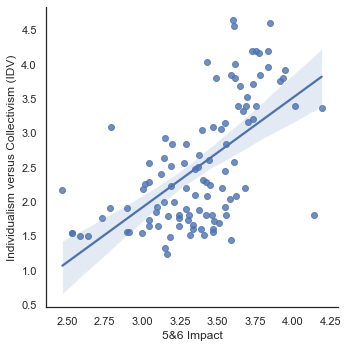

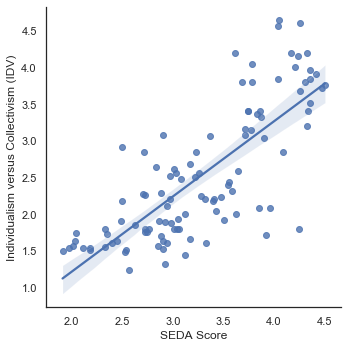

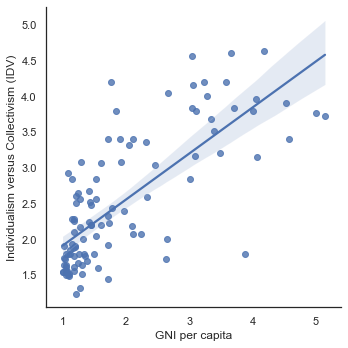

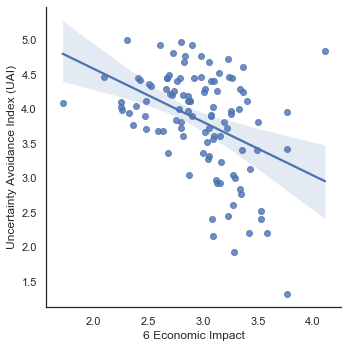

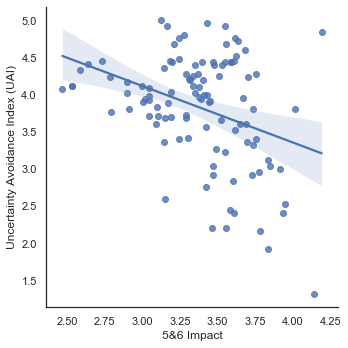

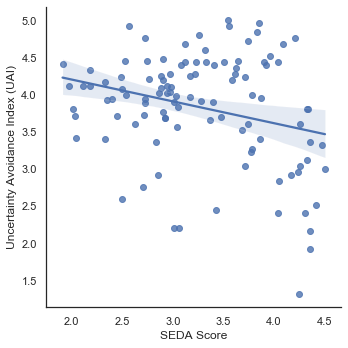

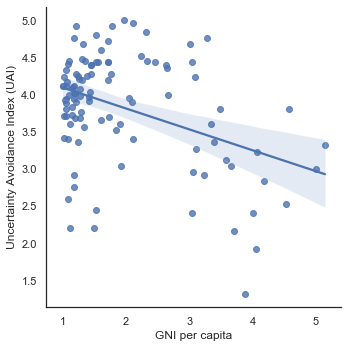

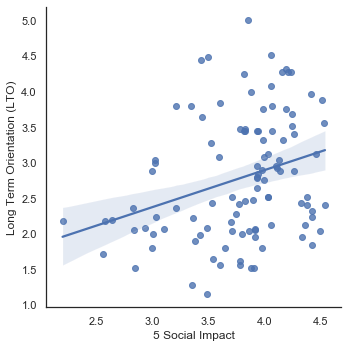

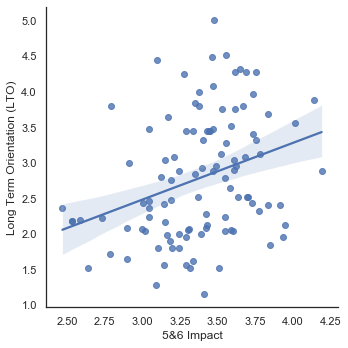

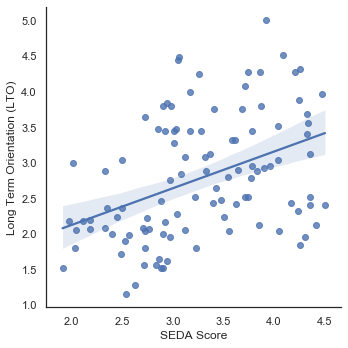

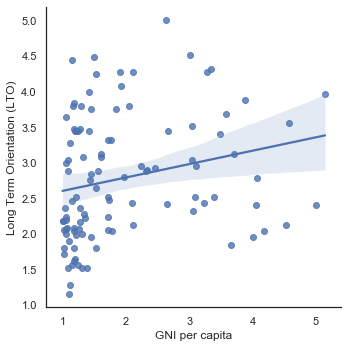

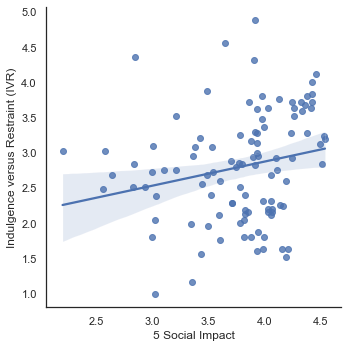

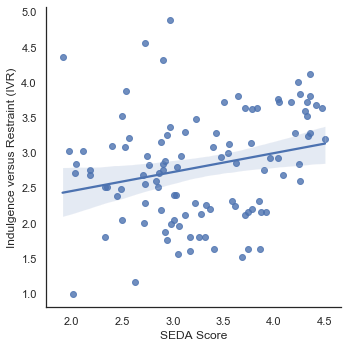

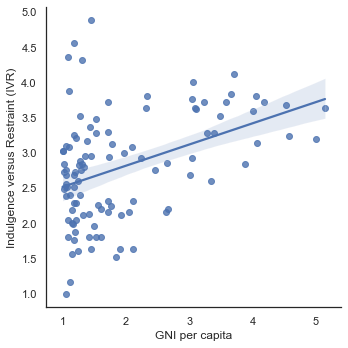

In [314]:
columns = list(i_e_unified.columns)
impacts = ['5 Social Impact', '6 Economic Impact', '5&6 Impact', 'SEDA Score', 'GNI per capita']
for c1 in hofstede_pillars:
    print('_-_-_-_-_-_-_-_')
    print(c1)
    print('_-_-_-_-_-_-_-_')
    #for c2 in columns:
    for c2 in impacts:
        if c1!=c2 and significant_corr(i_e_unified,i_e_unified,c1,c2)[0]==True:
            #correl = significant_corr(i_e_unified,i_e_unified,c1,c2)
            #print(c2, np.round(correl[1],4), correl[2])
            print_significant_corr(i_e_unified,i_e_unified,c1,c2)
            print('')
            print('')
            print('')

In [315]:
from IPython.core import display as ICD

columns = list(i_e_unified.columns)
impacts = ['5 Social Impact', '6 Economic Impact', '5&6 Impact', 'SEDA Score', 'GNI per capita']
for c1 in hofstede_pillars:
    print('***********')
    print(c1)
    print('***********')
    ICD.display( significant_corr_many(i_e_unified,i_e_unified,c1,impacts, 'Type of Impact') )
    print('')



***********
Power Distance Index (PDI)
***********


,Type of Impact,Pearson Correlation,Pvalue
0,5 Social Impact,-0.544735,1.574416e-09
1,6 Economic Impact,-0.181354,6.281821e-02
2,5&6 Impact,-0.495262,6.767828e-08
3,SEDA Score,-0.672412,2.956594e-15
4,GNI per capita,-0.727133,1.090410e-18



***********
Individualism versus Collectivism (IDV)
***********


,Type of Impact,Pearson Correlation,Pvalue
0,5 Social Impact,0.632531,3.512543e-13
1,6 Economic Impact,0.266626,5.731989e-03
2,5&6 Impact,0.607041,5.270348e-12
3,SEDA Score,0.775960,1.539313e-22
4,GNI per capita,0.745793,4.676138e-20



***********
Masculinity versus Feminity (MAS)
***********


,Type of Impact,Pearson Correlation,Pvalue



***********
Uncertainty Avoidance Index (UAI)
***********


,Type of Impact,Pearson Correlation,Pvalue
0,5 Social Impact,-0.168420,0.084386
1,6 Economic Impact,-0.413451,0.000011
2,5&6 Impact,-0.356910,0.000173
3,SEDA Score,-0.274591,0.004392
4,GNI per capita,-0.402410,0.000019



***********
Long Term Orientation (LTO)
***********


,Type of Impact,Pearson Correlation,Pvalue
0,5 Social Impact,0.298632,0.001875
1,6 Economic Impact,0.181673,0.062349
2,5&6 Impact,0.318412,0.000880
3,SEDA Score,0.410343,0.000013
4,GNI per capita,0.229098,0.018164



***********
Indulgence versus Restraint (IVR)
***********


,Type of Impact,Pearson Correlation,Pvalue
0,5 Social Impact,0.220290,0.023263
1,5&6 Impact,0.174417,0.073749
2,SEDA Score,0.240204,0.013132
3,GNI per capita,0.411046,0.000012


## Parte 6: Correlación de métricas de colaboración con Impacto

Estudiaremos qué correlaciones tienen cada una de las métricas de colaboratividad con aquellas de impacto. 

Para ello, vamos a ordenar los datos de los pilares de Impacto Social y Económico de:
* Argentina
* Brasil
* Chile
* España
* México
* Uruguay

Y vamos a leer la correlación de ambos impactos con cada una de las 11 métricas de colaboratividad con que contamos. Es decir, la métrica original y las 10 propuestas.

In [316]:
# primero conseguimos los datos de los 6 países estudiados
countries={'Mexico':'México',
          'Uruguay':'Uruguay',
          'Spain':'España',
          'Brazil':'Brasil',
          'Argentina':'Argentina',
          'Chile':'Chile'}
df_means_countries_studied = df_means.loc[list(countries.keys()), :]
df_means_countries_studied.rename(index=countries, inplace=True)

df1 = df_means_countries_studied[['5 Social Impact', 
                                  '6 Economic Impact',
                                  'GNI per capita',
                                  'SEDA Score',
                                  'Power Distance Index (PDI)',
                                  'Individualism versus Collectivism (IDV)', 
                                  'Masculinity versus Feminity (MAS)',
                                  'Uncertainty Avoidance Index (UAI)',
                                  'Long Term Orientation (LTO)', 
                                  'Indulgence versus Restraint (IVR)']]

#DataFrame con 5&6 Impacto
df_before_impact_split = pd.read_csv('PromediosPilares.csv')
df_before_impact_split.rename(columns={'Unnamed: 0':'Country', '5 Impact':'5&6 Impact'}, inplace=True)
df_before_impact_split.set_index('Country', inplace=True)
df2=df_before_impact_split[['5&6 Impact']]

#now we obtain colaborativities for each city
capitals = ['CABA', 'CDMX', 'Santiago', 'Montevideo', 'Madrid', 'Sao Paulo']
df3 = pd.read_csv('Ranking_cities.csv')[['Ciudad', 'País', 'Colab 10', 'Colab 10 rescaled', 'Ranking 10', 'Ranking Capitals 10']]
df3 = df3.loc[df3['Ciudad'].isin(capitals)]
df3 = df3.drop('Ciudad', axis=1)
df3.rename(columns={'País':'Country'}, inplace=True)
df3.set_index('Country', inplace=True)

#df1
#df2
#df3


#and finally we concatenate!
df_countries_studied = pd.concat([df1, df2, df3], axis=1)
df_countries_studied

,5 Social Impact,6 Economic Impact,GNI per capita,SEDA Score,Power Distance Index (PDI),Individualism versus Collectivism (IDV),Masculinity versus Feminity (MAS),Uncertainty Avoidance Index (UAI),Long Term Orientation (LTO),Indulgence versus Restraint (IVR),5&6 Impact,Colab 10,Colab 10 rescaled,Ranking 10,Ranking Capitals 10
México,3.916166,2.665218,1.440818,2.968,4.24,2.20,3.76,4.28,1.96,4.88,3.725455,0.397667,4.976668,10,5.0
Uruguay,4.495705,2.605598,1.772041,3.560,3.44,2.44,2.52,4.92,2.04,3.12,4.147576,0.588490,6.884901,2,1.0
España,4.111115,2.675696,2.461763,3.900,3.28,3.04,2.68,4.44,2.92,2.76,3.864545,0.426240,5.262402,8,4.0
Brasil,3.996738,2.389177,1.426206,2.972,3.76,2.52,2.96,4.04,2.76,3.36,3.671818,0.384944,4.849443,11,6.0
Argentina,3.984246,2.405071,1.527034,3.232,2.96,2.84,3.24,4.44,1.80,3.48,3.781818,0.492850,5.928502,3,2.0
Chile,4.424643,2.676299,1.712616,3.504,3.52,1.92,2.12,4.44,2.24,3.72,4.091818,0.480988,5.809878,4,3.0


In [317]:
impacts = ['5 Social Impact', '6 Economic Impact', '5&6 Impact', 'GNI per capita', 'SEDA Score']
others = list(i_e_unified.columns)
for i in impacts:
    others.remove(i)
    
significants = {x:[] for x in impacts}


df_correls = pd.DataFrame()
df_correls['Correl data'] = others
for i in impacts:
    booleans_i = []
    correls_i = []
    p_vals_i = []
    for c in others:
        triple = significant_corr(i_e_unified,i_e_unified,i,c)
        booleans_i.append(triple[0])
        correls_i.append(triple[1])
        p_vals_i.append(triple[2])
        if triple[0]==True:
            significants[i].append(c)
    df_correls['Significant with '+str(i)] = booleans_i
    df_correls['R^2 with '+str(i)] = correls_i
    df_correls['P-value with '+str(i)] = p_vals_i

    
df_correls       

,Correl data,Significant with 5 Social Impact,R^2 with 5 Social Impact,P-value with 5 Social Impact,Significant with 6 Economic Impact,R^2 with 6 Economic Impact,P-value with 6 Economic Impact,Significant with 5&6 Impact,R^2 with 5&6 Impact,P-value with 5&6 Impact,Significant with GNI per capita,R^2 with GNI per capita,P-value with GNI per capita,Significant with SEDA Score,R^2 with SEDA Score,P-value with SEDA Score
0,1 Foundational Institutions,True,0.745562,4.870233e-20,True,0.312428,0.001112,True,0.714467,8.005771e-18,True,0.786011,1.873851e-23,True,0.893702,5.492319e-38
1,2 Innovation Capacity,True,0.585575,4.306874e-11,True,0.300101,0.001775,True,0.592352,2.256263e-11,True,0.795492,2.311159e-24,True,0.795598,2.256645e-24
2,3 Entrepreneurship Capacity,True,0.365156,1.187382e-04,False,0.181777,0.062197,True,0.366325,1.124778e-04,True,0.550295,9.921683e-10,True,0.493270,7.779256e-08
3,4 Comparative Advantage,True,0.372081,8.587891e-05,True,0.343901,0.000307,True,0.463753,5.540241e-07,True,0.720854,2.970113e-18,True,0.534350,3.647727e-09
4,Individualism versus Collectivism (IDV),True,0.632531,3.512543e-13,True,0.266626,0.005732,True,0.607041,5.270348e-12,True,0.745793,4.676138e-20,True,0.775960,1.539313e-22
5,Indulgence versus Restraint (IVR),True,0.220290,2.326319e-02,False,0.027976,0.775894,False,0.174417,7.374860e-02,True,0.411046,1.203923e-05,True,0.240204,1.313239e-02
6,Long Term Orientation (LTO),True,0.298632,1.874514e-03,False,0.181673,0.062349,True,0.318412,8.797426e-04,True,0.229098,1.816433e-02,True,0.410343,1.250145e-05
7,Masculinity versus Feminity (MAS),False,-0.112756,2.498109e-01,False,-0.027401,0.780385,False,-0.096735,3.239097e-01,False,-0.055758,5.702363e-01,False,-0.089622,3.609216e-01
8,Power Distance Index (PDI),True,-0.544735,1.574416e-09,False,-0.181354,0.062818,True,-0.495262,6.767828e-08,True,-0.727133,1.090410e-18,True,-0.672412,2.956594e-15
9,Uncertainty Avoidance Index (UAI),False,-0.168420,8.438598e-02,True,-0.413451,0.000011,True,-0.356910,1.729877e-04,True,-0.402410,1.901355e-05,True,-0.274591,4.392112e-03


## Parte 7: Correlación de iEcos con métricas de los grafos

Hacemos lo mismo de arriba, solo que esta vez incluiremos todas las métricas de los grafos, y todas las métricas de iEcosystems. Sin y con unificación de las Capacidades de Innovación y Emprendimiento.

#### Sin unificación

Primero conseguimos 
  *  `df1`: los datos de los 6 países estudiados
  *  `df2`: columna mostrando la medida de impacto anterior a la separación en impacto social y económico
  *  `df3`: información de las colaboratividades de cada ciudad

Y luego, los unificamos en `df_i_e_separate`, un DataFrame que seguiremos estudiando.

In [318]:
#DF1 df_means restringido a los 6 paises estudiados
countries={'Mexico':'México', 'Uruguay':'Uruguay', 'Spain':'España', 'Brazil':'Brasil', 'Argentina':'Argentina', 'Chile':'Chile'}
df_means_countries_studied = df_means.loc[list(countries.keys()), :]
df_means_countries_studied.rename(index=countries, inplace=True)
df1 = df_means_countries_studied

#DF3 vieja medida de impacto
df_before_impact_split = pd.read_csv('PromediosPilares.csv')
df_before_impact_split.rename(columns={'Unnamed: 0':'Country', '5 Impact':'Impact Before'}, inplace=True)
df_before_impact_split.set_index('Country', inplace=True)
df2=df_before_impact_split[['Impact Before']]

#DF3 colaboratividad por ciudad 
capitals = ['CABA', 'CDMX', 'Santiago', 'Montevideo', 'Madrid', 'Sao Paulo']
df3 = pd.read_csv('Ranking_cities.csv')
df3 = df3[['Ciudad', 'País', 'Colab 10', 'Ranking Capitals 10']]
df3 = df3.loc[df3['Ciudad'].isin(capitals)]
df3 = df3.drop('Ciudad', axis=1)
df3.rename(columns={'País':'Country'}, inplace=True)
df3.set_index('Country', inplace=True)

#df1
#df2
#df3


#and finally we concatenate!
df_i_e_separate = pd.concat([df1, df2, df3], axis=1)
df_i_e_separate

,1 Foundational Institutions,2.01 I-Human Capital,2.02 I-Funding,2.03 I-Infrastructure,2.04 I-Demand,2.05 I-Culture & Incentives,3.01 E-Human Capital,3.02 E-Funding,3.03 E-Infrastructure,3.04 E-Demand,...,Individualism versus Collectivism (IDV),Indulgence versus Restraint (IVR),Long Term Orientation (LTO),Masculinity versus Feminity (MAS),Power Distance Index (PDI),SEDA Score,Uncertainty Avoidance Index (UAI),Impact Before,Colab 10,Ranking Capitals 10
México,3.5224,2.363914,1.238062,2.782979,3.102667,2.5160,3.117368,2.299475,3.701600,3.4260,...,2.20,4.88,1.96,3.76,4.24,2.968,4.28,3.725455,0.397667,5.0
Uruguay,3.7808,2.346297,1.464989,2.833698,2.578222,1.2428,3.046434,2.006035,3.926000,2.7408,...,2.44,3.12,2.04,2.52,3.44,3.560,4.92,4.147576,0.588490,1.0
España,3.9268,2.822386,1.899159,3.191020,3.077333,3.8300,3.189806,2.423851,4.264933,3.3650,...,3.04,2.76,2.92,2.68,3.28,3.900,4.44,3.864545,0.426240,4.0
Brasil,3.1780,1.826706,1.675010,2.707140,2.879111,2.7542,2.975761,1.991287,3.694933,3.4638,...,2.52,3.36,2.76,2.96,3.76,2.972,4.04,3.671818,0.384944,6.0
Argentina,3.1684,2.021985,1.682002,2.740698,2.729778,1.7930,3.076940,1.725475,3.679067,3.1718,...,2.84,3.48,1.80,3.24,2.96,3.232,4.44,3.781818,0.492850,2.0
Chile,3.9124,2.399177,1.184934,3.100109,2.965778,1.9536,4.154179,2.207990,3.935067,3.2030,...,1.92,3.72,2.24,2.12,3.52,3.504,4.44,4.091818,0.480988,3.0


#### Con unificación I&E

Primero conseguimos 
  *  `df1`: los datos de los 6 países estudiados, con Innovación y Emprendimiento unificados
  *  `df2`: columna mostrando la medida de impacto anterior a la separación en impacto social y económico
  *  `df3`: información de las colaboratividades de cada ciudad

Y luego, los unificamos en `df_i_e_unified`, un DataFrame que seguiremos estudiando.

In [319]:
#DF1 i_e_unified restringido a los 6 paises estudiados
countries={'Mexico':'México', 'Uruguay':'Uruguay', 'Spain':'España', 'Brazil':'Brasil', 'Argentina':'Argentina', 'Chile':'Chile'}
df_means_countries_studied = i_e_unified.loc[list(countries.keys()), :]
df_means_countries_studied.rename(index=countries, inplace=True)
df1 = df_means_countries_studied

#DF3 vieja medida de impacto
df_before_impact_split = pd.read_csv('PromediosPilares.csv')
df_before_impact_split.rename(columns={'Unnamed: 0':'Country', '5 Impact':'Impact Before'}, inplace=True)
df_before_impact_split.set_index('Country', inplace=True)
df2=df_before_impact_split[['Impact Before']]

#DF3 colaboratividad por ciudad 
capitals = ['CABA', 'CDMX', 'Santiago', 'Montevideo', 'Madrid', 'Sao Paulo']
df3 = pd.read_csv('Ranking_cities.csv')
df3 = df3[['Ciudad', 'País', 'Colab 10', 'Ranking Capitals 10']]  #

for i in range(len(df3['Ranking Capitals 10'])):
    df3['Ranking Capitals 10'][i] *= -1
    df3['Ranking Capitals 10'][i] += 7

df3 = df3.loc[df3['Ciudad'].isin(capitals)]                       #only take capital cities
df3 = df3.drop('Ciudad', axis=1)
df3.rename(columns={'País':'Country', 'Ranking Capitals 10':'Inverted Ranking Capitals 10'}, inplace=True)
df3.set_index('Country', inplace=True)

#df1
#df2
#df3


#and finally we concatenate!
df_i_e_unified = pd.concat([df1, df2, df3], axis=1)
df_i_e_unified

/Users/olga/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/olga/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,1 Foundational Institutions,2 Innovation Capacity,3 Entrepreneurship Capacity,4 Comparative Advantage,5 Social Impact,6 Economic Impact,GNI per capita,Individualism versus Collectivism (IDV),Indulgence versus Restraint (IVR),Long Term Orientation (LTO),Masculinity versus Feminity (MAS),Power Distance Index (PDI),SEDA Score,Uncertainty Avoidance Index (UAI),2&3 I&E Capacity,5&6 Impact,Impact Before,Colab 10,Inverted Ranking Capitals 10
México,3.5224,2.346874,2.932019,2.928133,3.916166,2.665218,1.440818,2.20,4.88,1.96,3.76,4.24,2.968,4.28,2.639447,3.290692,3.725455,0.397667,2.0
Uruguay,3.7808,2.174806,2.826071,2.482667,4.495705,2.605598,1.772041,2.44,3.12,2.04,2.52,3.44,3.560,4.92,2.500438,3.550652,4.147576,0.588490,6.0
España,3.9268,2.853591,2.954476,2.839333,4.111115,2.675696,2.461763,3.04,2.76,2.92,2.68,3.28,3.900,4.44,2.904034,3.393406,3.864545,0.426240,3.0
Brasil,3.1780,2.267103,2.956201,2.741067,3.996738,2.389177,1.426206,2.52,3.36,2.76,2.96,3.76,2.972,4.04,2.611652,3.192957,3.671818,0.384944,1.0
Argentina,3.1684,2.198670,2.696591,2.583067,3.984246,2.405071,1.527034,2.84,3.48,1.80,3.24,2.96,3.232,4.44,2.447630,3.194659,3.781818,0.492850,5.0
Chile,3.9124,2.330033,3.188631,3.111200,4.424643,2.676299,1.712616,1.92,3.72,2.24,2.12,3.52,3.504,4.44,2.759332,3.550471,4.091818,0.480988,4.0


***********************************************
Innovation and Entrepreneurship Separated
***********************************************


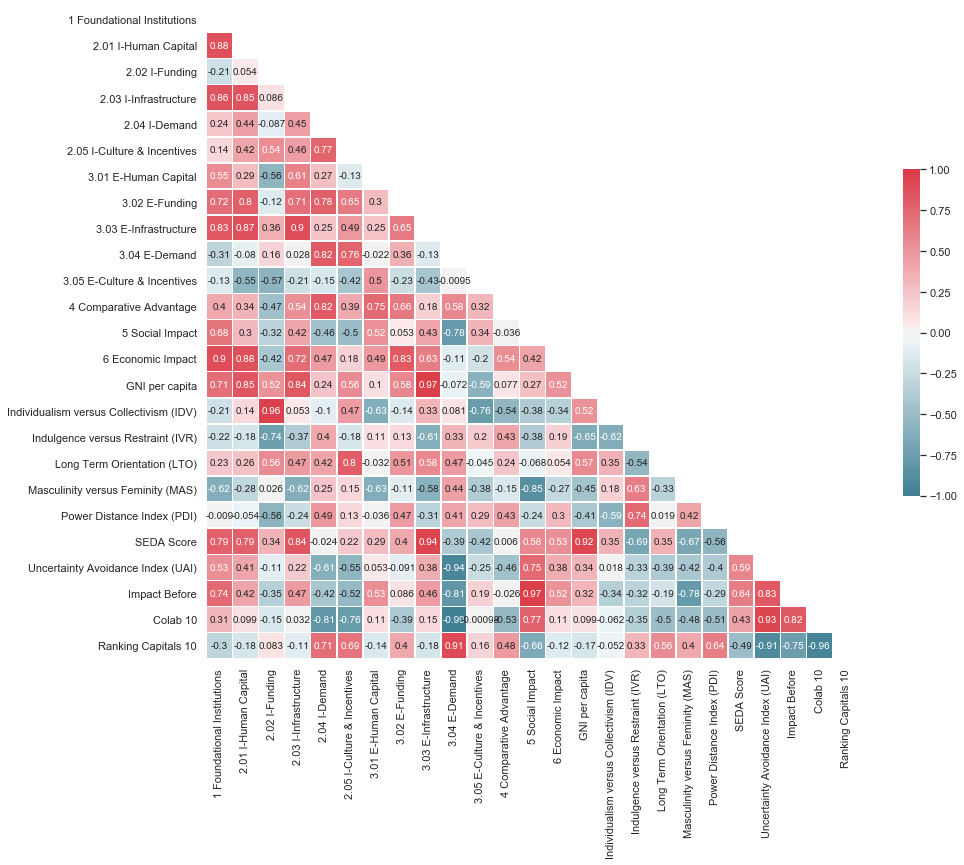

In [320]:
print('***********************************************')
print('Innovation and Entrepreneurship Separated')
print('***********************************************')

corr = df_i_e_separate.corr()

import seaborn as sns
sns.set(style="white")

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(16, 12))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap,annot=True,vmin=-1, vmax=1, center=0,
            square=True, linewidths=.6, cbar_kws={"shrink": .5}, annot_kws={'size':10})

***********************************************
Innovation and Entrepreneurship Unified
***********************************************


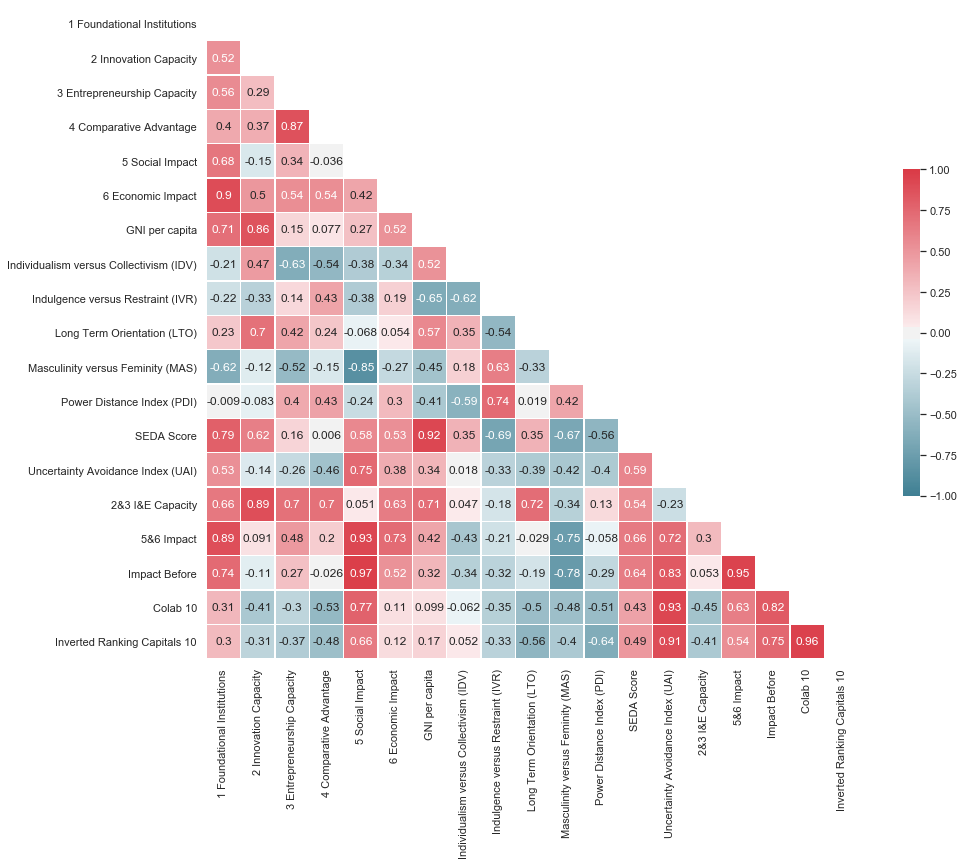

In [321]:
print('***********************************************')
print('Innovation and Entrepreneurship Unified')
print('***********************************************')

corr = df_i_e_unified.corr()

import seaborn as sns
sns.set(style="white")

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(16, 12))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap,annot=True,vmin=-1, vmax=1, center=0,
            square=True, linewidths=.6, cbar_kws={"shrink": .5})

In [322]:
print('***********************************************')
print('Metrics, iEco, and Hofstede DataFrame')
print('***********************************************')

all_df=df_i_e_unified.copy()
placeholder=pd.read_csv('Tidy_DataFrame.csv')
capitalnames = ['CDMX', 'CABA', 'Santiago', 'Sao Paulo', 'Madrid', 'Montevideo']
placeholder = placeholder.loc[placeholder['Ciudad'].isin(capitalnames)]

#index: País
placeholder = placeholder.drop('Ciudad',axis=1)
placeholder.set_index('País', inplace=True)

all_df=pd.concat([all_df,placeholder],axis=1)
all_df=all_df.drop('Weighted Degree',axis=1)
all_df=all_df.drop('weight',axis=1)
all_df=all_df.drop('Camino más corto promedio',axis=1)
for i in range(15):
    all_df=all_df.drop('Colab '+str(i),axis=1)
all_df

***********************************************
Metrics, iEco, and Hofstede DataFrame
***********************************************


,1 Foundational Institutions,2 Innovation Capacity,3 Entrepreneurship Capacity,4 Comparative Advantage,5 Social Impact,6 Economic Impact,GNI per capita,Individualism versus Collectivism (IDV),Indulgence versus Restraint (IVR),Long Term Orientation (LTO),...,Transitividad,Eficiencia Global,Small Worldness,Rich Club Coefficient,Core Ratio,Central Point Dominance,Spectral radius,Modularidad,Average Collaborations,Colab 10 rescaled
México,3.5224,2.346874,2.932019,2.928133,3.916166,2.665218,1.440818,2.20,4.88,1.96,...,0.050000,0.289320,0.614973,0.361111,0.421405,0.202,1.910,0.623,12.33,4.976668
Uruguay,3.7808,2.174806,2.826071,2.482667,4.495705,2.605598,1.772041,2.44,3.12,2.04,...,0.224523,0.360837,1.197588,1.000000,0.565657,0.179,1.778,0.356,13.40,6.884901
España,3.9268,2.853591,2.954476,2.839333,4.111115,2.675696,2.461763,3.04,2.76,2.92,...,0.081917,0.294653,0.930159,1.000000,0.439331,0.184,1.920,0.606,12.13,5.262402
Brasil,3.1780,2.267103,2.956201,2.741067,3.996738,2.389177,1.426206,2.52,3.36,2.76,...,0.078571,0.266719,1.071208,0.222222,0.421296,0.237,1.983,0.682,10.38,4.849443
Argentina,3.1684,2.198670,2.696591,2.583067,3.984246,2.405071,1.527034,2.84,3.48,1.80,...,0.107392,0.325773,1.006481,0.866667,0.495614,0.251,1.868,0.527,13.48,5.928502
Chile,3.9124,2.330033,3.188631,3.111200,4.424643,2.676299,1.712616,1.92,3.72,2.24,...,0.100744,0.338889,1.051860,1.000000,0.430769,0.525,1.890,0.535,13.04,5.809878


***********************************************
Graph metrics, iEco, and Hofstede Correlations
***********************************************


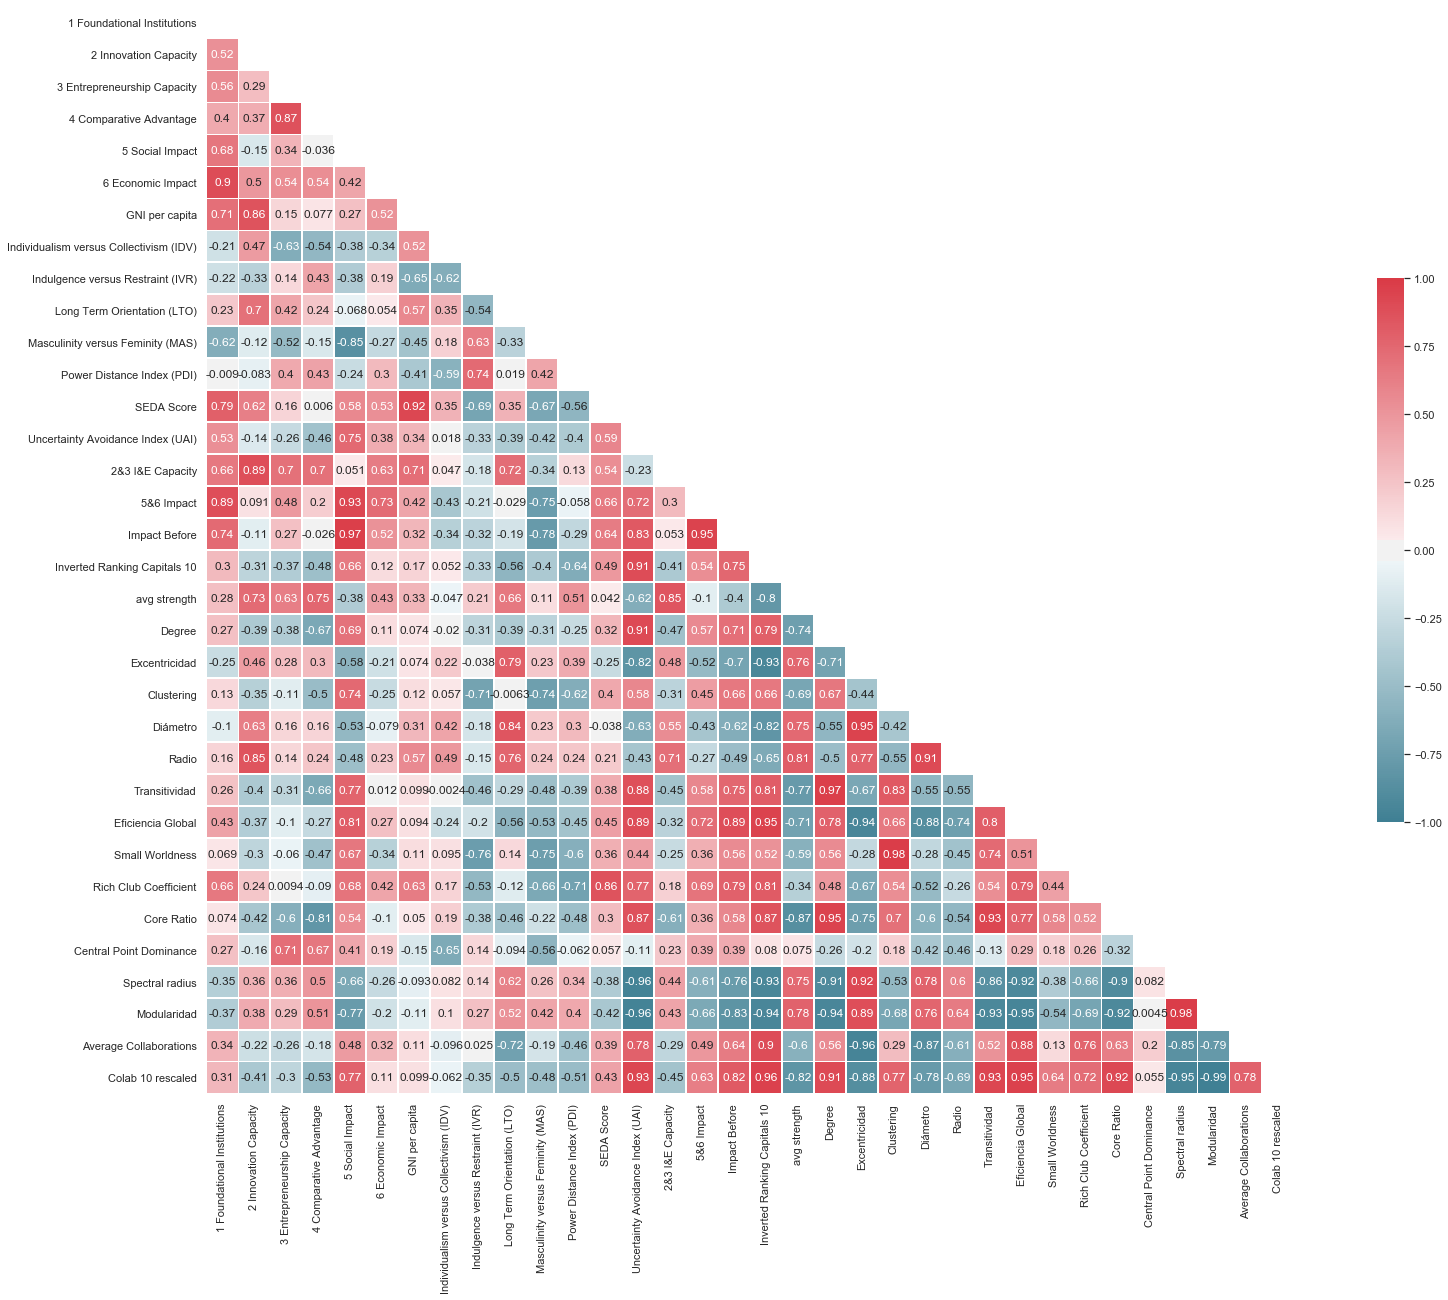

In [323]:
print('***********************************************')
print('Graph metrics, iEco, and Hofstede Correlations')
print('***********************************************')

corr = all_df.corr()

import seaborn as sns
sns.set(style="white")

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(30, 20))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap,annot=True,vmin=-1, vmax=1, center=0,
            square=True, linewidths=.6, cbar_kws={"shrink": .5})

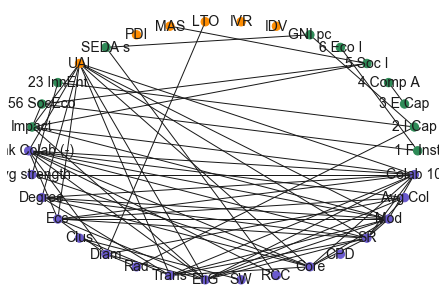

In [324]:
def visualize_heatmap(df, color_sets=None, c_labels=None):
    '''
    correl_df :     Pandas DataFrame in which correlations between 
    aggrupations :  Dictionary, mapping  
    '''
    G = nx.Graph()
    columns=df.columns
    for c in columns:
        G.add_node(c)
    for c1 in columns:
        for c2 in columns:
            s = significant_corr(df,df,c1,c2)
            if c1!=c2 and s[0]==True:
                G.add_edge(c1, c2, pearson=s[1], pval=s[2])
    #print(columns)   
    color_code = None
    if color_sets!=None:
        color_code = [color_sets[c] for c in columns]
        
    nx.draw_circular(G, with_labels=True, node_size=70, node_color=color_code, labels=c_labels, font_size=14)  # use spring layout
    return

color_dict = {'1 Foundational Institutions': '#2E8B57',
                   '2 Innovation Capacity': '#2E8B57',
                   '3 Entrepreneurship Capacity': '#2E8B57',
                   '4 Comparative Advantage': '#2E8B57',
                   '5 Social Impact': '#2E8B57', 
                   '6 Economic Impact': '#2E8B57',
                   'GNI per capita': '#2E8B57',
                   'Individualism versus Collectivism (IDV)': '#FF8C00',
                   'Indulgence versus Restraint (IVR)': '#FF8C00', 
                   'Long Term Orientation (LTO)': '#FF8C00',
                   'Masculinity versus Feminity (MAS)': '#FF8C00',
                   'Power Distance Index (PDI)': '#FF8C00',
                   'SEDA Score': '#2E8B57', 
                   'Uncertainty Avoidance Index (UAI)': '#FF8C00', 
                   '2&3 I&E Capacity': '#2E8B57',
                   '5&6 Impact': '#2E8B57', 
                   'Impact Before': '#2E8B57', 
                   'Inverted Ranking Capitals 10': '#6A5ACD',
                   'avg strength': '#6A5ACD', 
                   'Degree': '#6A5ACD', 
                   'Excentricidad': '#6A5ACD', 
                   'Clustering': '#6A5ACD', 
                   'Diámetro': '#6A5ACD',
                   'Radio': '#6A5ACD', 
                   'Transitividad': '#6A5ACD',
                   'Eficiencia Global': '#6A5ACD', 
                   'Small Worldness': '#6A5ACD',
                   'Rich Club Coefficient': '#6A5ACD', 
                   'Core Ratio': '#6A5ACD', 
                   'Central Point Dominance': '#6A5ACD',
                   'Spectral radius': '#6A5ACD', 
                   'Modularidad': '#6A5ACD', 
                   'Average Collaborations': '#6A5ACD',
                   'Colab 10 rescaled': '#6A5ACD'}

label_dict = {'1 Foundational Institutions': '1 F Inst',
                   '2 Innovation Capacity': '2 I Cap',
                   '3 Entrepreneurship Capacity': '3 E Cap',
                   '4 Comparative Advantage': '4 Comp A',
                   '5 Social Impact': '5 Soc I', 
                   '6 Economic Impact': '6 Eco I',
                   'GNI per capita': 'GNI pc',
                   'Individualism versus Collectivism (IDV)': 'IDV',
                   'Indulgence versus Restraint (IVR)': 'IVR', 
                   'Long Term Orientation (LTO)': 'LTO',
                   'Masculinity versus Feminity (MAS)': 'MAS',
                   'Power Distance Index (PDI)': 'PDI',
                   'SEDA Score': 'SEDA s', 
                   'Uncertainty Avoidance Index (UAI)': 'UAI', 
                   '2&3 I&E Capacity': '23 InnEnt',
                   '5&6 Impact': '56 SocEco', 
                   'Impact Before': 'Impact', 
                   'Inverted Ranking Capitals 10': 'Rank Colab (-)',
                   'avg strength': 'avg strength', 
                   'Degree': 'Degree', 
                   'Excentricidad': 'Ecc', 
                   'Clustering': 'Clus', 
                   'Diámetro': 'Diam',
                   'Radio': 'Rad', 
                   'Transitividad': 'Trans',
                   'Eficiencia Global': 'EfiG', 
                   'Small Worldness': 'SW',
                   'Rich Club Coefficient': 'RCC', 
                   'Core Ratio': 'Core', 
                   'Central Point Dominance': 'CPD',
                   'Spectral radius': 'SR', 
                   'Modularidad': 'Mod', 
                   'Average Collaborations': 'Avg Col',
                   'Colab 10 rescaled': 'Colab 10'}

visualize_heatmap(all_df, color_sets=color_dict, c_labels=label_dict)

    
    

********
Power Distance Index (PDI)
********
********
Individualism versus Collectivism (IDV)
********
********
Masculinity versus Feminity (MAS)
********
Correlation between:  Masculinity versus Feminity (MAS)   and   5 Social Impact
**********************************************
Pearson Correlation: -0.8524810268736023, p-value: 0.03103762845512961
*Statistically significant*
***********************************************


********
Uncertainty Avoidance Index (UAI)
********
Correlation between:  Uncertainty Avoidance Index (UAI)   and   Impact Before
**********************************************
Pearson Correlation: 0.8344229960197125, p-value: 0.038853907973470894
*Statistically significant*
***********************************************


Correlation between:  Uncertainty Avoidance Index (UAI)   and   Colab 10 rescaled
**********************************************
Pearson Correlation: 0.9335816841623402, p-value: 0.006470590381957405
*Statistically significant*
***************

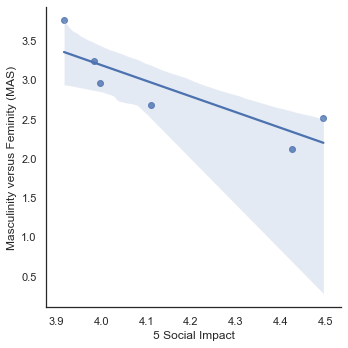

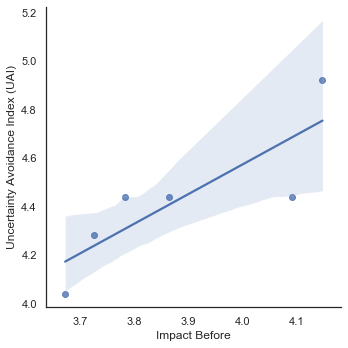

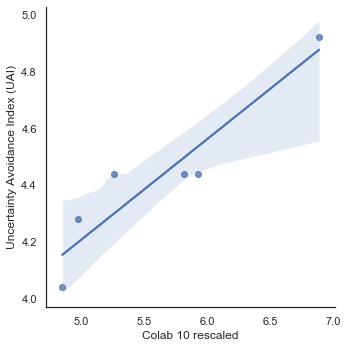

In [325]:
#columns = ['5 Social Impact', '6 Economic Impact', 'Impact Before', 'GNI per capita', 'SEDA Score', 'Colab 10 rescaled']
columns = ['5 Social Impact', '6 Economic Impact', 'Impact Before', 'Colab 10 rescaled']

for c1 in hofstede_pillars:
    print('********')
    print(c1)
    print('********')
    for c2 in columns:
        if c1!=c2 and significant_corr(all_df,all_df,c1,c2)[0]==True:
            #correl = significant_corr(i_e_unified,i_e_unified,c1,c2)
            #print(c2, np.round(correl[1],4), correl[2])
            print_significant_corr(all_df,all_df,c1,c2)
            print('')


In [326]:
columns = ['5 Social Impact', '6 Economic Impact', 'Impact Before', 'GNI per capita', 'SEDA Score', 'Colab 10 rescaled']
for c1 in hofstede_pillars:
    print('********')
    print(c1)
    print('********')
    ICD.display( significant_corr_many(all_df,all_df,c1,columns,'Column') )
    print('')
    

********
Power Distance Index (PDI)
********


,Column,Pearson Correlation,Pvalue



********
Individualism versus Collectivism (IDV)
********


,Column,Pearson Correlation,Pvalue



********
Masculinity versus Feminity (MAS)
********


,Column,Pearson Correlation,Pvalue
0,5 Social Impact,-0.852481,0.031038
1,Impact Before,-0.780699,0.066866
2,SEDA Score,-0.673742,0.142302



********
Uncertainty Avoidance Index (UAI)
********


,Column,Pearson Correlation,Pvalue
0,5 Social Impact,0.748765,0.086750
1,Impact Before,0.834423,0.038854
2,Colab 10 rescaled,0.933582,0.006471



********
Long Term Orientation (LTO)
********


,Column,Pearson Correlation,Pvalue



********
Indulgence versus Restraint (IVR)
********


,Column,Pearson Correlation,Pvalue
0,GNI per capita,-0.645065,0.166611
1,SEDA Score,-0.694317,0.125881


### Correlaciones significativas par a part entre pilares de iEco y dimensiones de Hofstede

Por último en esta sección, vamos a imprimir aquellas correlaciones que son significativas. 

In [327]:
L=list(df_i_e_unified.columns)
for a in L:
    print('********')
    print(a)
    print('********')
    ICD.display( significant_corr_many(df_i_e_unified , df_i_e_unified , a , L ,'Column') )
    

********
1 Foundational Institutions
********


,Column,Pearson Correlation,Pvalue
0,1 Foundational Institutions,1.000000,7.395571e-32
1,5 Social Impact,0.679406,1.376954e-01
2,6 Economic Impact,0.904313,1.329586e-02
3,GNI per capita,0.708515,1.150626e-01
4,Masculinity versus Feminity (MAS),-0.624199,1.853030e-01
5,SEDA Score,0.793717,5.943986e-02
6,2&3 I&E Capacity,0.662890,1.513094e-01
7,5&6 Impact,0.886815,1.849119e-02
8,Impact Before,0.735493,9.569279e-02


********
2 Innovation Capacity
********


,Column,Pearson Correlation,Pvalue
0,2 Innovation Capacity,1.000000,1.848893e-32
1,GNI per capita,0.860901,2.767696e-02
2,Long Term Orientation (LTO),0.700570,1.210646e-01
3,SEDA Score,0.624913,1.846497e-01
4,2&3 I&E Capacity,0.885081,1.905085e-02


********
3 Entrepreneurship Capacity
********


,Column,Pearson Correlation,Pvalue
0,3 Entrepreneurship Capacity,1.000000,1.664003e-31
1,4 Comparative Advantage,0.870478,2.407749e-02
2,Individualism versus Collectivism (IDV),-0.628960,1.809657e-01
3,2&3 I&E Capacity,0.700342,1.212387e-01


********
4 Comparative Advantage
********


,Column,Pearson Correlation,Pvalue
0,3 Entrepreneurship Capacity,0.870478,0.024077
1,4 Comparative Advantage,1.000000,0.000000
2,2&3 I&E Capacity,0.702471,0.119616


********
5 Social Impact
********


,Column,Pearson Correlation,Pvalue
0,1 Foundational Institutions,0.679406,1.376954e-01
1,5 Social Impact,1.000000,7.395571e-32
2,Masculinity versus Feminity (MAS),-0.852481,3.103763e-02
3,Uncertainty Avoidance Index (UAI),0.748765,8.674961e-02
4,5&6 Impact,0.925869,8.039382e-03
5,Impact Before,0.974439,9.716857e-04
6,Colab 10,0.774697,7.042358e-02
7,Inverted Ranking Capitals 10,0.655269,1.577756e-01


********
6 Economic Impact
********


,Column,Pearson Correlation,Pvalue
0,1 Foundational Institutions,0.904313,0.013296
1,6 Economic Impact,1.000000,0.000000
2,2&3 I&E Capacity,0.633223,0.177117
3,5&6 Impact,0.731414,0.098520


********
GNI per capita
********


,Column,Pearson Correlation,Pvalue
0,1 Foundational Institutions,0.708515,0.115063
1,2 Innovation Capacity,0.860901,0.027677
2,GNI per capita,1.000000,0.000000
3,Indulgence versus Restraint (IVR),-0.645065,0.166611
4,SEDA Score,0.923729,0.008504
5,2&3 I&E Capacity,0.714725,0.110465


********
Individualism versus Collectivism (IDV)
********


,Column,Pearson Correlation,Pvalue
0,3 Entrepreneurship Capacity,-0.628960,0.180966
1,Individualism versus Collectivism (IDV),1.000000,0.000000
2,Indulgence versus Restraint (IVR),-0.621816,0.187490


********
Indulgence versus Restraint (IVR)
********


,Column,Pearson Correlation,Pvalue
0,GNI per capita,-0.645065,1.666113e-01
1,Individualism versus Collectivism (IDV),-0.621816,1.874899e-01
2,Indulgence versus Restraint (IVR),1.000000,7.395571e-32
3,Masculinity versus Feminity (MAS),0.627027,1.827215e-01
4,Power Distance Index (PDI),0.739837,9.272268e-02
5,SEDA Score,-0.694317,1.258809e-01


********
Long Term Orientation (LTO)
********


,Column,Pearson Correlation,Pvalue
0,2 Innovation Capacity,0.700570,1.210646e-01
1,Long Term Orientation (LTO),1.000000,1.848893e-32
2,2&3 I&E Capacity,0.724433,1.034425e-01


********
Masculinity versus Feminity (MAS)
********


,Column,Pearson Correlation,Pvalue
0,1 Foundational Institutions,-0.624199,1.853030e-01
1,5 Social Impact,-0.852481,3.103763e-02
2,Indulgence versus Restraint (IVR),0.627027,1.827215e-01
3,Masculinity versus Feminity (MAS),1.000000,7.395571e-32
4,SEDA Score,-0.673742,1.423019e-01
5,5&6 Impact,-0.751692,8.483020e-02
6,Impact Before,-0.780699,6.686593e-02


********
Power Distance Index (PDI)
********


,Column,Pearson Correlation,Pvalue
0,Indulgence versus Restraint (IVR),0.739837,0.092723
1,Power Distance Index (PDI),1.000000,0.000000
2,Inverted Ranking Capitals 10,-0.636816,0.173901


********
SEDA Score
********


,Column,Pearson Correlation,Pvalue
0,1 Foundational Institutions,0.793717,5.943986e-02
1,2 Innovation Capacity,0.624913,1.846497e-01
2,GNI per capita,0.923729,8.504046e-03
3,Indulgence versus Restraint (IVR),-0.694317,1.258809e-01
4,Masculinity versus Feminity (MAS),-0.673742,1.423019e-01
5,SEDA Score,1.000000,7.395571e-32
6,5&6 Impact,0.655985,1.571631e-01
7,Impact Before,0.636238,1.744176e-01


********
Uncertainty Avoidance Index (UAI)
********


,Column,Pearson Correlation,Pvalue
0,5 Social Impact,0.748765,0.086750
1,Uncertainty Avoidance Index (UAI),1.000000,0.000000
2,5&6 Impact,0.719860,0.106725
3,Impact Before,0.834423,0.038854
4,Colab 10,0.933582,0.006471
5,Inverted Ranking Capitals 10,0.905486,0.012977


********
2&3 I&E Capacity
********


,Column,Pearson Correlation,Pvalue
0,1 Foundational Institutions,0.662890,0.151309
1,2 Innovation Capacity,0.885081,0.019051
2,3 Entrepreneurship Capacity,0.700342,0.121239
3,4 Comparative Advantage,0.702471,0.119616
4,6 Economic Impact,0.633223,0.177117
5,GNI per capita,0.714725,0.110465
6,Long Term Orientation (LTO),0.724433,0.103443
7,2&3 I&E Capacity,1.000000,0.000000


********
5&6 Impact
********


,Column,Pearson Correlation,Pvalue
0,1 Foundational Institutions,0.886815,0.018491
1,5 Social Impact,0.925869,0.008039
2,6 Economic Impact,0.731414,0.098520
3,Masculinity versus Feminity (MAS),-0.751692,0.084830
4,SEDA Score,0.655985,0.157163
5,Uncertainty Avoidance Index (UAI),0.719860,0.106725
6,5&6 Impact,1.000000,0.000000
7,Impact Before,0.948098,0.003971
8,Colab 10,0.626079,0.183585


********
Impact Before
********


,Column,Pearson Correlation,Pvalue
0,1 Foundational Institutions,0.735493,9.569279e-02
1,5 Social Impact,0.974439,9.716857e-04
2,Masculinity versus Feminity (MAS),-0.780699,6.686593e-02
3,SEDA Score,0.636238,1.744176e-01
4,Uncertainty Avoidance Index (UAI),0.834423,3.885391e-02
5,5&6 Impact,0.948098,3.970807e-03
6,Impact Before,1.000000,1.848893e-32
7,Colab 10,0.823935,4.376951e-02
8,Inverted Ranking Capitals 10,0.753919,8.338304e-02


********
Colab 10
********


,Column,Pearson Correlation,Pvalue
0,5 Social Impact,0.774697,0.070424
1,Uncertainty Avoidance Index (UAI),0.933582,0.006471
2,5&6 Impact,0.626079,0.183585
3,Impact Before,0.823935,0.043770
4,Colab 10,1.000000,0.000000
5,Inverted Ranking Capitals 10,0.958668,0.002527


********
Inverted Ranking Capitals 10
********


,Column,Pearson Correlation,Pvalue
0,5 Social Impact,0.655269,1.577756e-01
1,Power Distance Index (PDI),-0.636816,1.739011e-01
2,Uncertainty Avoidance Index (UAI),0.905486,1.297726e-02
3,Impact Before,0.753919,8.338304e-02
4,Colab 10,0.958668,2.527224e-03
5,Inverted Ranking Capitals 10,1.000000,7.395571e-32


## Part 8: Spider Comparisons

Ahora vamos a hacer visualizaciones tales como mapas de araña para comparar los datos que conocemos de dos capitales. 

In [328]:
#@title Función de spider plot
def make_spider_comparison(df ,country_name1, country_name2):
    from math import pi
    categories=list(df)
    N = len(categories)
  
    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]
    fig = plt.figure(figsize=(8, 8))
    # Initialise the spider plot
    ax = plt.subplot(111, polar=True)
  
    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)
    # Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1], categories )
    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks([1,2,3,4,5], ["1","2","3","4",""], color="grey", size=13)
    plt.ylim(0,5)
  
  
    # ------- PART 2: Add plots
  
    # Plot each individual = each line of the data
    # I don't do a loop, because plotting more than 3 groups makes the chart unreadable
  
    # Ind1
    values=df.loc[country_name1].values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=1, linestyle='solid', label=country_name1)
    ax.fill(angles, values, 'b', alpha=0.1)
  
    # Ind2
    values=df.loc[country_name2].values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=1, linestyle='solid', label=country_name2)
    ax.fill(angles, values, 'r', alpha=0.1)
  
    # Add legend
    plt.legend( bbox_to_anchor=(0.05, 0.25))
    plt.tight_layout()

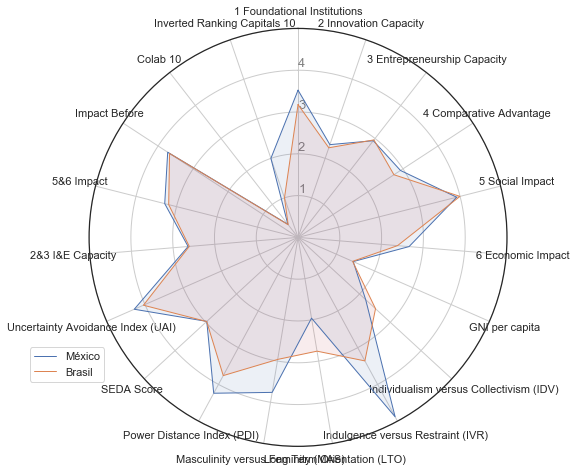

In [329]:
#make_spider_comparison(df_means,'Mexico','Uruguay')
make_spider_comparison(df_i_e_unified,'México','Brasil')

In [330]:
only_iecos = df_means.drop(['GNI per capita','SEDA Score'], axis = 1)
#only_iecos

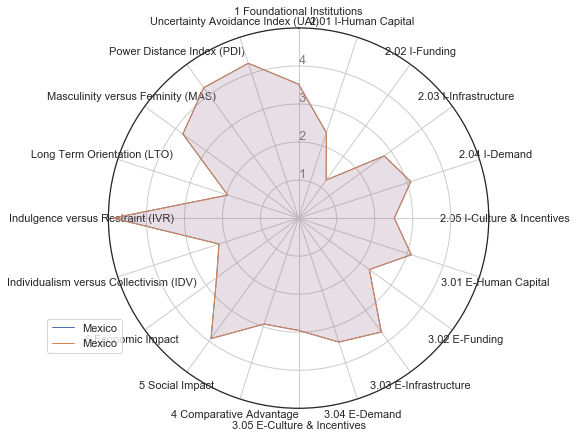

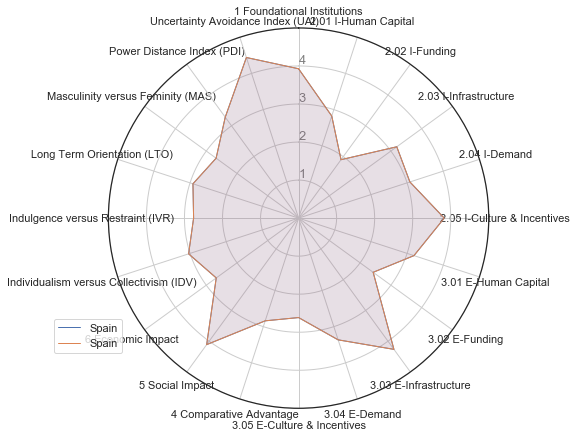

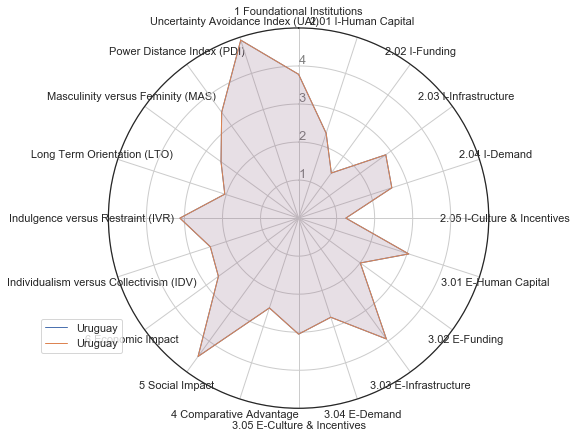

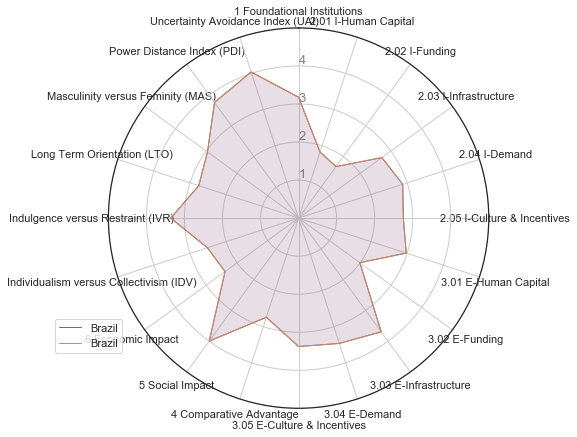

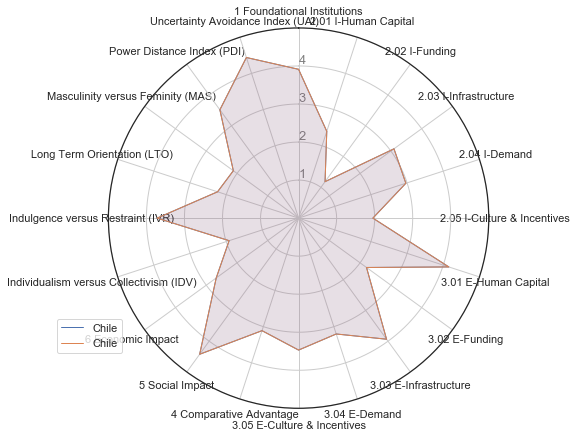

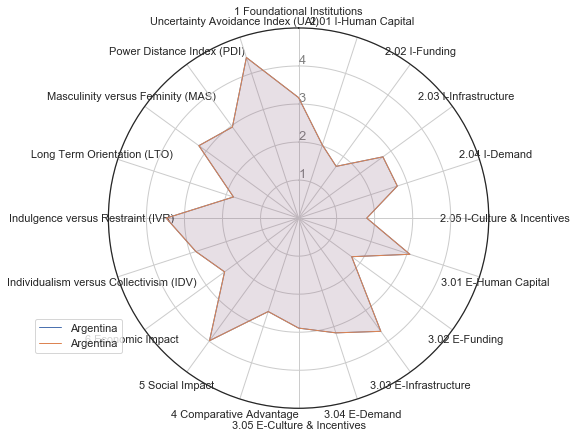

In [331]:
#-------------------------------------------
# Spider Web visualization of each country
#-------------------------------------------

paises=['México', 'España', 'Uruguay', 'Brasil', 'Chile', 'Argentina']
countries=['Mexico', 'Spain', 'Uruguay', 'Brazil', 'Chile', 'Argentina']


for country1 in countries:
    for country2 in countries:
        if country1==country2:
            make_spider_comparison(only_iecos,country1,country2)
            

## Parte 9: Principal Component Analysis

This part utilizes Principal Component Analysis in order to visualize the set of studied countries, separated by: 
*  Cultural Group
*  Development stage of its economy
*  Continent

In [332]:
%pip install plotly==4.9.0
import plotly.express as px

Note: you may need to restart the kernel to use updated packages.


##### First: Using Data only from iEcosystems pilars

In [333]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
pca.fit(only_iecos)
print(f"La varianza explicada es: {np.sum(pca.explained_variance_ratio_)} %")


print('')
print('PCA explained variance ratio')
print(pca.explained_variance_ratio_)

La varianza explicada es: 0.6438309886404782 %

PCA explained variance ratio
[0.40777726 0.14377097 0.09228276]


In [334]:
Components_df = pd.DataFrame({
    "Component_1": pca.components_[0],
    "Component_2": pca.components_[1],
    "Component_3": pca.components_[2],
    "Pilar" : only_iecos.columns})
Components_df.set_index('Pilar',inplace=True)

Components_df

,Component_1,Component_2,Component_3
Pilar,,,
1 Foundational Institutions,0.222799,0.003666,-0.128837
2.01 I-Human Capital,0.246716,0.012619,-0.010214
2.02 I-Funding,0.268126,0.127543,0.168100
2.03 I-Infrastructure,0.253892,-0.029135,-0.120600
2.04 I-Demand,0.191597,-0.018500,0.170829
2.05 I-Culture & Incentives,0.275966,0.252698,0.507721
3.01 E-Human Capital,-0.029480,-0.064913,0.025617
3.02 E-Funding,0.245064,-0.122160,0.080909
3.03 E-Infrastructure,0.241301,0.044787,-0.086108


In [335]:
#aquí podemos observar en el primer componente, cuáles métricas contribuyen más/menos
Components_df['Component_1'].sort_values(ascending=False)

Pilar
Individualism versus Collectivism (IDV)    0.441176
2.05 I-Culture & Incentives                0.275966
2.02 I-Funding                             0.268126
2.03 I-Infrastructure                      0.253892
2.01 I-Human Capital                       0.246716
3.02 E-Funding                             0.245064
3.03 E-Infrastructure                      0.241301
1 Foundational Institutions                0.222799
4 Comparative Advantage                    0.212529
Long Term Orientation (LTO)                0.211117
5 Social Impact                            0.195262
2.04 I-Demand                              0.191597
3.04 E-Demand                              0.188147
Indulgence versus Restraint (IVR)          0.112515
6 Economic Impact                          0.075174
Masculinity versus Feminity (MAS)          0.020275
3.01 E-Human Capital                      -0.029480
3.05 E-Culture & Incentives               -0.039766
Uncertainty Avoidance Index (UAI)         -0.205343
Power 

In [336]:
#mismo para el segundo componente
Components_df['Component_2'].sort_values(ascending=False)

Pilar
Long Term Orientation (LTO)                0.660310
2.05 I-Culture & Incentives                0.252698
Power Distance Index (PDI)                 0.208363
2.02 I-Funding                             0.127543
Uncertainty Avoidance Index (UAI)          0.089695
Masculinity versus Feminity (MAS)          0.088920
3.03 E-Infrastructure                      0.044787
3.04 E-Demand                              0.014402
2.01 I-Human Capital                       0.012619
1 Foundational Institutions                0.003666
6 Economic Impact                         -0.002752
2.04 I-Demand                             -0.018500
5 Social Impact                           -0.018866
2.03 I-Infrastructure                     -0.029135
3.01 E-Human Capital                      -0.064913
Individualism versus Collectivism (IDV)   -0.085435
3.05 E-Culture & Incentives               -0.096200
3.02 E-Funding                            -0.122160
4 Comparative Advantage                   -0.159249
Indulg

In [337]:
#mismo, para el tercer componente
Components_df['Component_3'].sort_values(ascending=False)

Pilar
2.05 I-Culture & Incentives                0.507721
Masculinity versus Feminity (MAS)          0.389396
Power Distance Index (PDI)                 0.355460
3.04 E-Demand                              0.328570
4 Comparative Advantage                    0.181209
2.04 I-Demand                              0.170829
2.02 I-Funding                             0.168100
Indulgence versus Restraint (IVR)          0.137706
3.05 E-Culture & Incentives                0.088252
3.02 E-Funding                             0.080909
3.01 E-Human Capital                       0.025617
2.01 I-Human Capital                      -0.010214
6 Economic Impact                         -0.031819
3.03 E-Infrastructure                     -0.086108
2.03 I-Infrastructure                     -0.120600
1 Foundational Institutions               -0.128837
Uncertainty Avoidance Index (UAI)         -0.197741
5 Social Impact                           -0.199386
Long Term Orientation (LTO)               -0.206638
Indivi

In [349]:
import math
def replace_nan(arr):
    arr2 = arr.copy()
    for i in range(len(arr2)):
        if type(arr2[i])!=str and math.isnan(arr2[i])==True:
            arr2[i] = 'Other'
    return arr2

Scores = pca.transform(only_iecos)
Score_df = pd.DataFrame({
    "Component_1": Scores[:,0],
    "Component_2": Scores[:,1],
    "Component_3": Scores[:,2],
    "Country" :df.index,
    "Region" :df['Region'],
    "Development Stage" : df['Development Stage'],
    "Region":df['Region'], 
    "Region 2":replace_nan(df['Region 2'])
})


Score_df

,Component_1,Component_2,Component_3,Country,Region,Development Stage,Region 2
Country,,,,,,,
Albania,-1.405608,1.228327,-0.821173,Albania,Europe and Central Asia,Economies in transition,Europa
Algeria,-1.053116,0.077180,0.436950,Algeria,Middle East and North Africa,Developing economies,Oriente Medio
Argentina,-0.523066,-1.059895,-0.194208,Argentina,Latin America and the Caribbean,Developing economies,Iberoamérica
Armenia,-0.678347,0.753711,-0.678922,Armenia,Europe and Central Asia,Economies in transition,Other
Australia,2.584042,-1.586007,0.217347,Australia,East Asia and Pacific,Developed economies,Other
...,...,...,...,...,...,...,...
United Kingdom,4.004271,-0.721121,1.073213,United Kingdom,Europe and Central Asia,Developed economies,Europa
United States,4.876697,-1.687500,1.902608,United States,North America,Developed economies,Other
Uruguay,-0.818491,-0.769658,-1.080138,Uruguay,Latin America and the Caribbean,Developing economies,Iberoamérica


In [352]:
#fig = px.scatter_3d(Score_df, x='Component_1', y='Component_2', z='Component_3', color='Development Stage', text='Country')
#fig = px.scatter_3d(Score_df, x='Component_1', y='Component_2', z='Component_3', color='Region', text='Country')
fig = px.scatter_3d(Score_df, x='Component_1', y='Component_2', z='Component_3', color='Region 2', text='Country')

#fig.show()

##### Second: Using Data only from Hofstede dimensions

In [353]:
only_hofstedes = df_imputed [ hofstede_pillars ]
#only_hofstedes

In [354]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
pca.fit(only_hofstedes)
print(f"La varianza explicada es: {np.sum(pca.explained_variance_ratio_)} %")


print('')
print('PCA explained variance ratio')
print(pca.explained_variance_ratio_)

La varianza explicada es: 0.7727656386856455 %

PCA explained variance ratio
[0.38745739 0.26476382 0.12054443]


In [355]:
Components_df = pd.DataFrame({
    "Component_1": pca.components_[0],
    "Component_2": pca.components_[1],
    "Component_3": pca.components_[2],
    "Pilar" : only_hofstedes.columns})
Components_df.set_index('Pilar',inplace=True)

Components_df

,Component_1,Component_2,Component_3
Pilar,,,
Power Distance Index (PDI),-0.545645,0.133663,0.265759
Individualism versus Collectivism (IDV),0.710932,0.001802,-0.148840
Masculinity versus Feminity (MAS),-0.000409,0.040228,0.177479
Uncertainty Avoidance Index (UAI),-0.316613,0.011330,-0.925875
Long Term Orientation (LTO),0.252262,0.757373,-0.109705
Indulgence versus Restraint (IVR),0.181568,-0.637786,-0.080253


In [356]:
#aquí podemos observar en el primer componente, cuáles métricas contribuyen más/menos
Components_df['Component_1'].sort_values(ascending=False)

Pilar
Individualism versus Collectivism (IDV)    0.710932
Long Term Orientation (LTO)                0.252262
Indulgence versus Restraint (IVR)          0.181568
Masculinity versus Feminity (MAS)         -0.000409
Uncertainty Avoidance Index (UAI)         -0.316613
Power Distance Index (PDI)                -0.545645
Name: Component_1, dtype: float64

In [357]:
#mismo para el segundo componente
Components_df['Component_2'].sort_values(ascending=False)

Pilar
Long Term Orientation (LTO)                0.757373
Power Distance Index (PDI)                 0.133663
Masculinity versus Feminity (MAS)          0.040228
Uncertainty Avoidance Index (UAI)          0.011330
Individualism versus Collectivism (IDV)    0.001802
Indulgence versus Restraint (IVR)         -0.637786
Name: Component_2, dtype: float64

In [358]:
#mismo, para el tercer componente
Components_df['Component_3'].sort_values(ascending=False)

Pilar
Power Distance Index (PDI)                 0.265759
Masculinity versus Feminity (MAS)          0.177479
Indulgence versus Restraint (IVR)         -0.080253
Long Term Orientation (LTO)               -0.109705
Individualism versus Collectivism (IDV)   -0.148840
Uncertainty Avoidance Index (UAI)         -0.925875
Name: Component_3, dtype: float64

In [360]:
Scores = pca.transform(only_hofstedes)
Score_df = pd.DataFrame({
    "Component_1": Scores[:,0],
    "Component_2": Scores[:,1],
    "Component_3": Scores[:,2],
    "Country" :df.index,
    "Region" :df['Region'],
    "Development Stage" : df['Development Stage'],
    "Region":df['Region'], 
    "Region 2":replace_nan(df['Region 2'])
})


Score_df

,Component_1,Component_2,Component_3,Country,Region,Development Stage,Region 2
Country,,,,,,,
Albania,-0.910033,1.288219,-0.212563,Albania,Europe and Central Asia,Economies in transition,Europa
Algeria,-0.506739,-0.220941,0.098667,Algeria,Middle East and North Africa,Developing economies,Oriente Medio
Argentina,0.229159,-1.233018,-0.649544,Argentina,Latin America and the Caribbean,Developing economies,Iberoamérica
Armenia,-0.121967,1.041507,0.053183,Armenia,Europe and Central Asia,Economies in transition,Other
Australia,2.239114,-1.495781,0.270004,Australia,East Asia and Pacific,Developed economies,Other
...,...,...,...,...,...,...,...
United Kingdom,2.766894,-0.551228,0.746897,United Kingdom,Europe and Central Asia,Developed economies,Europa
United States,2.315870,-1.257664,0.465275,United States,North America,Developed economies,Other
Uruguay,-0.473625,-0.781734,-1.032087,Uruguay,Latin America and the Caribbean,Developing economies,Iberoamérica


In [361]:
#fig = px.scatter_3d(Score_df, x='Component_1', y='Component_2', z='Component_3', color='Development Stage', text='Country')
#fig = px.scatter_3d(Score_df, x='Component_1', y='Component_2', z='Component_3', color='Region', text='Country')
fig = px.scatter_3d(Score_df, x='Component_1', y='Component_2', z='Component_3', color='Region 2', text='Country')

fig.show()

## Buscando parejas de métricas correlacionadas significativamente

In [366]:
iecosystems_m=['1 Foundational Institutions', '2.01 I-Human Capital', '2.02 I-Funding', '2.03 I-Infrastructure', '2.04 I-Demand',
      '2.05 I-Culture & Incentives', '3.01 E-Human Capital', '3.02 E-Funding', '3.03 E-Infrastructure', '3.04 E-Demand', 
      '3.05 E-Culture & Incentives', '4 Comparative Advantage', '5 Impact']

global_m=['avg strength', 'weight', 'Degree', 'Weighted Degree', 'Eccentricidad', 'Clustering',
          'Diámetro', 'Radio', 'Camino más corto promedio', 'Transitividad', 'Eficiencia Global', 
          'Small Worldness', 'Core Ratio', 'Central Point Dominance', 'Spectral radius']

significant_pairs=[]
for a in iecosystems_m:
    for b in global_m:
        if significant_corr(all_df, all_df, a, b)[0]:
            significant_pairs.append((a,b))

significant_pairs


KeyError: 'weight'

In [ ]:
df_graph_ieco_with_detail = pd.concat([df_imputed,Graph_df], axis = 1)
df_graph_ieco_with_detail

In [ ]:
i_funding_components = ['2.02a R&D expenditure as a % GDP (UNESCO)',
                       '2.02b R&D expenditure in \'000 current PPP$ (UNESCO)',
                       '2.02c Public R&D Expenditure as % of total R&D expenditure (UNESCO)',
                       '2.02d Business Expenditure as % of total R&D expenditure (UNESCO)']

e_funding_components = ['3.02a VC investment',
                       '3.02b Financing of SME\'s (GCI 4.0)',
                       '3.02c Venture Capital Availability (GCI 4.0)',
                       '3.02d Ease of Credit (GII)',
                       '3.02e VC deals (GII)',
                       '3.02f Venture Capital Deal Volume']

comparative_advantage_components = ['4.01 State of cluster development (GCI 4.0)',
                                   '4.02 Country capacity to attract and retain talent']

impact_components = ['5.01 GDP per capita',
                    '5.02 Social Progress Index',
                    '5.03 Inclusive Development Index',
                    '5.04 Population below international poverty line (SDG 1 - No poverty)',
                    '5.05 Prevalence of undernourishment (SDG 2 - Zero Hunger)',
                    '5.06 Annual growth rate of real GDP per capita (SDG 8 - Decent Jobs and Economic Growth)',
                    '5.07 Unemployment rate of population 15 years of age and older (SDG 8 - Decent Jobs and Economic Growth)',
                    '5.08 Carbon dioxide emissions per unit of GDP (SDG 9 - Industry, Innovation and Infrastructure)',
                    '5.09 Proportion of urban population living in slums (SDG 11 - Sustainable Cities and Communities)',
                    '5.10 Annual population-weighted average mean concentration of fine suspended particles of less than 2.5 microns in diameter (SDG 11 - Sustainable Cities and Communities)',
                    '5.11 Domestic material consumption per capita (SDG 12 - Responsible Consumption and Production)']

collab_metrics = Graph_df.columns.values.tolist()
collab_metrics = collab_metrics[-16:]


In [ ]:
# ---
# correlations between I Funding and Comparative Advantage
# ---


significant_positives = []
significant_negatives = []

for a in i_funding_components:
    for b in comparative_advantage_components:
        CORR = check_corr_significance(df_graph_ieco_with_detail,df_graph_ieco_with_detail,a,b)
        if CORR[0]:
            if CORR[1]>0:
                significant_positives.append((a,b))
            else:
                significant_negatives.append((a,b))

for a,b in significant_positives:
    print('')
    print_corr_significance(df_graph_ieco_with_detail,a,b)
    
for a,b in significant_negatives:
    print('')
    print_corr_significance(df_graph_ieco_with_detail,a,b)
    

In [ ]:
# ---
# correlations between E Funding and Comparative Advantage
# ---


significant_positives = []
significant_negatives = []

for a in e_funding_components:
    for b in comparative_advantage_components:
        CORR = check_corr_significance(df_graph_ieco_with_detail,df_graph_ieco_with_detail,a,b)
        if CORR[0]:
            if CORR[1]>0:
                significant_positives.append((a,b))
            else:
                significant_negatives.append((a,b))


for a,b in significant_positives:
    print('')
    print_corr_significance(df_graph_ieco_with_detail,a,b)
    
for a,b in significant_negatives:
    print('')
    print_corr_significance(df_graph_ieco_with_detail,a,b)

In [ ]:
# ---
# correlations between I Funding and Impact
# ---


significant_positives = []
significant_negatives = []

for a in i_funding_components:
    for b in impact_components:
        CORR = check_corr_significance(df_graph_ieco_with_detail,df_graph_ieco_with_detail,a,b)
        if CORR[0]:
            if CORR[1]>0:
                significant_positives.append((a,b))
            else:
                significant_negatives.append((a,b))

for a,b in significant_positives:
    print('')
    print_corr_significance(df_graph_ieco_with_detail,a,b)
    
for a,b in significant_negatives:
    print('')
    print_corr_significance(df_graph_ieco_with_detail,a,b)

In [ ]:
# ---
# correlations between E Funding and Impact
# ---


significant_positives = []
significant_negatives = []

for a in e_funding_components:
    for b in impact_components:
        CORR = check_corr_significance(df_graph_ieco_with_detail,df_graph_ieco_with_detail,a,b)
        if CORR[0]:
            if CORR[1]>0:
                significant_positives.append((a,b))
            else:
                significant_negatives.append((a,b))

for a,b in significant_positives:
    print('')
    print_corr_significance(df_graph_ieco_with_detail,a,b)
    
for a,b in significant_negatives:
    print('')
    print_corr_significance(df_graph_ieco_with_detail,a,b)

In [ ]:
# ---
# correlations between Colaboration and Impact
# ---


significant_positives = []
significant_negatives = []

for a in collab_metrics:
    for b in impact_components:
        CORR = check_corr_significance(df_graph_ieco_with_detail,df_graph_ieco_with_detail,a,b)
        if CORR[0]:
            if CORR[1]>0:
                significant_positives.append((a,b))
            else:
                significant_negatives.append((a,b))

for a,b in significant_positives:
    print('')
    print_corr_significance(df_graph_ieco_with_detail,a,b)
    
for a,b in significant_negatives:
    print('')
    print_corr_significance(df_graph_ieco_with_detail,a,b)

In [ ]:
# ---
# correlations between Colaboration and Comparative Advantage
# ---


significant_positives = []
significant_negatives = []

for a in collab_metrics:
    for b in comparative_advantage_components:
        CORR = check_corr_significance(df_graph_ieco_with_detail,df_graph_ieco_with_detail,a,b)
        if CORR[0]:
            if CORR[1]>0:
                significant_positives.append((a,b))
            else:
                significant_negatives.append((a,b))

for a,b in significant_positives:
    print('')
    print_corr_significance(df_graph_ieco_with_detail,a,b)
    
for a,b in significant_negatives:
    print('')
    print_corr_significance(df_graph_ieco_with_detail,a,b)

In [ ]:
Graph_df

In [ ]:
#-------------------------------------------
# Scaling 1-5 parameters per country
#-------------------------------------------


negative_type_metrics = ['Eccentricidad', 'Diámetro', 'Radio', 
                         'Camino más corto promedio', 'Central Point Dominance', 'Spectral radius']

Graph_df_copy=Graph_df.copy()

mins = {metric: min(Graph_df[metric].to_list()) for metric in list(Graph_df)}
maxs = {metric: max(Graph_df[metric].to_list()) for metric in list(Graph_df)}


# Proceso de re-escalamiento de 0 a 1
for col in Graph_df_copy.columns:
    Graph_df_copy[col] = Graph_df_copy[col].apply(lambda x: (x-mins[col])/(maxs[col]-mins[col]))

# Rescalamiento de 1 a 5    
Graph_df_copy = np.round((Graph_df_copy*4)+1,2)

# Invertimos la escala de aquellas métricas de tipo negativo
for col in negative_type_metrics:
    Graph_df_copy[col] = Graph_df_copy[col].apply(lambda x: abs(5-x)+1)

Graph_df_copy
